# Analysis of Travel Dataset: Guide to India's Must See Places

In [813]:
#Import libarys
import pandas as pd
import math
import pingouin as pg
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy as sp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.express as px
import plotly
import plotly.graph_objects as go
from plotly.graph_objs import Scatter, Figure, Histogram, Layout, Bar
plotly.offline.init_notebook_mode(connected = True)
from plotly.subplots import make_subplots
from geopy.geocoders import Nominatim
from pypalettes import load_cmap
from pypalettes import get_hex

## Introduction

This dataset was downloaded from [Kaggle](https://www.kaggle.com/datasets/saketk511/travel-dataset-guide-to-indias-must-see-places).

The data is loaded into the noteboook, and the head and shape is displayed for initial inspection.

Through the process of the following inspection, it is found that the dataset is completely without NaN values. The na_filter is set to False to avoid filtering string of 'None' in the variable that describes what day an attraction is not open.

In [2]:
#File renamed to 'data.csv' and saved in current working directory
with open('data.csv') as x:
    ncols = len(x.readline().split(','))

df_raw = pd.read_csv('data.csv', usecols=range(1,ncols), na_filter = False)

In [3]:
#Make a copy of the dataset to avoid the need to re-import
df = df_raw.copy()

In [4]:
#display dataframe head for initial inspection
df.head()

Zone  State   City                  Name          Type  \
0  Northern  Delhi  Delhi            India Gate  War Memorial   
1  Northern  Delhi  Delhi        Humayun's Tomb          Tomb   
2  Northern  Delhi  Delhi     Akshardham Temple        Temple   
3  Northern  Delhi  Delhi  Waste to Wonder Park    Theme Park   
4  Northern  Delhi  Delhi         Jantar Mantar   Observatory   

  Establishment Year  time needed to visit in hrs  Google review rating  \
0               1921                          0.5                   4.6   
1               1572                          2.0                   4.5   
2               2005                          5.0                   4.6   
3               2019                          2.0                   4.1   
4               1724                          2.0                   4.2   

   Entrance Fee in INR Airport with 50km Radius Weekly Off   Significance  \
0                    0                      Yes       None     Historical   
1                   30                      Yes       None     Historical   
2                   60                      Yes       None      Religious   
3                   50                      Yes     Monday  Environmental   
4                   15                      Yes       None     Scientific   

  DSLR Allowed  Number of google review in lakhs Best Time to visit  
0          Yes                              2.60            Evening  
1          Yes                              0.40          Afternoon  
2           No                              0.40          Afternoon  
3          Yes                              0.27            Evening  
4          Yes                              0.31            Morning

In [9]:
# Dataset shape
print(df.shape)
 
rows, columns = df.shape
print(f"The dataset comprises {rows} properties described across {columns} attributes.")

(325, 15)
The dataset comprises 325 properties described across 15 attributes.




<ul>
    <li>Data types are analysed to shape analysis approach.

In [2157]:
#Determine the data type for each feature
data_types = df.dtypes
 
# View a few datatypes from the dataset
print(data_types)

Zone                                 object
State                                object
City                                 object
Name                                 object
Type                                 object
Establishment Year                   object
time needed to visit in hrs         float64
Google review rating                float64
Entrance Fee in INR                   int64
Airport with 50km Radius             object
Weekly Off                           object
Significance                         object
DSLR Allowed                         object
Number of google review in lakhs    float64
Best Time to visit                   object
dtype: object


<ul>
    <li>
        Note that 'Establishment Year' is object, which is string type. This will need to be coverted to numerical for analysis.
    </li>

In [2159]:
# Tally the total by data type
type_counts = data_types.value_counts()
 
print(type_counts)

object     11
float64     3
int64       1
Name: count, dtype: int64


<ul>
    <li>Visualizing the Missing Values

In [2161]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

# Combining the counts and percentages into a DataFrame for better visualization
missing_info = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})

# Sorting the DataFrame by the percentage of missing values in descending order
missing_info = missing_info.sort_values(by='Percentage', ascending=False)

# Display columns with missing values
print(missing_info[missing_info['Missing Values'] > 0])

Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


<ul>
    <li>The dataset has no missing values. 

In [2129]:
# Check the structure of the dataset
print("\nStructure of the dataset:")
print(df.info())


Structure of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Zone                              325 non-null    object 
 1   State                             325 non-null    object 
 2   City                              325 non-null    object 
 3   Name                              325 non-null    object 
 4   Type                              325 non-null    object 
 5   Establishment Year                325 non-null    object 
 6   time needed to visit in hrs       325 non-null    float64
 7   Google review rating              325 non-null    float64
 8   Entrance Fee in INR               325 non-null    int64  
 9   Airport with 50km Radius          325 non-null    object 
 10  Weekly Off                        325 non-null    object 
 11  Significance                      325 non-nu

## Clean-up and transformations
Modify the dataframe to simplify and improve the data analysis approach.

In [11]:
# Convert column names to lowercase
df.columns = df.columns.str.lower()

#rename columns to make them easier to work with
df = df.rename(columns = {'establishment year':'year', 'time needed to visit in hrs':'time', 'google review rating':'rating',
                         'entrance fee in inr':'fee', 'airport with 50km radius':'airport', 'weekly off':'off',
                         'dslr allowed':'camera', 'number of google review in lakhs':'reviews', 'best time to visit':'visit'})

# convert Binary variables to numerical
df['camera_num'] = df['camera'].astype('category').cat.codes

df['airport_num'] = df['airport'].astype('category').cat.codes

# create binary column for 'visit' == 'Anytime'
df['anytime'] = pd.get_dummies(df['visit'])['Anytime']#.astype(int)

# Convert 'Establishment Year' to numeric based on conditions
df['year_num'] = df['year'].apply(lambda x: int(re.findall('[0-9-]+', x)[0]) * 100 if re.search("century", x) else (
    int(re.findall('[0-9-]+', x)[0])) if re.findall('[0-9-]+', x) != [] else np.nan)

# Clean visit variable category types
df['visit'] = df['visit'].str.strip().replace('All','Anytime').astype('category')

# Convert all elements in the 'city' column to Cap Case
df['city'] = df['city'].str.title()

In [15]:
df.shape

(325, 25)

## Feature Engineering
Additional numerical variables are created based on the existing variables.

'ratings' is normalized and log-scale columns are created for skewed variables.

In [13]:
#Add column for time periods
df['year_group'] = df['year_num'].apply(lambda x: 'Prehistoric' if x <= -3300 else (
    'Bronze Age' if x <= -1800 else ('Iron Age' if x <= -200 else (
        'Classical Period' if x <= 650 else ('Early Medieval Period' if x <= 1200 else (
        'Late Medieval Period' if x <= 1526 else ('Early Medieval Period' if x <= 1858 else(
            'Late Modern and Contemporary Period' if x <= 1947 else (
            'Independence and Partition' if x > 1947 else 'Unknown'
            )))))))))

#Create column for ratio of fee to time ("Value")
df['cost_ratio'] = df['fee'] / df['time']

#Normalize ratings column
scaler = StandardScaler()
df['rating_norm'] = scaler.fit_transform(df[['rating']])

#log scale skewed variables
df['fee_log'] = np.log1p(df['fee'])

df['reviews_log'] = np.log1p(df['reviews'])

df['cost_ratio_log'] = np.log1p(df['cost_ratio'])

In [697]:
clat = []
clon = []
cities = []

geolocator = Nominatim(user_agent="my_geocoder")


for city in df['city'].unique():
    
    location = geolocator.geocode(city)

    if location:
        clat.append(location.latitude)
        clon.append(location.longitude)
        cities.append(city)
    else:
        clat.append(np.nan)
        clon.append(np.nan)
        cities.append(city)

In [698]:
cgeo = pd.DataFrame({'city':cities, 'lat':clat, 'lon':clon}).set_index('city')

cgeo.loc['Dalhousie'] = [32.53, 75.98]
cgeo.loc['Auli'] = [30.52892, 79.57026]
cgeo.loc['Manas'] = [26.716667, 90.933333]
cgeo.loc['Barot'] = [32.036389, 76.8475]
cgeo.loc['Shoja'] = [31.5672, 77.3705]

df_geo = pd.merge(df,cgeo, on = 'city')

## Descriptive Statistics

Sanity check on descriptive statistics

In [203]:
# Descriptive statistics for numerical columns
print(df.describe())

             time      rating          fee     reviews  camera_num  \
count  325.000000  325.000000   325.000000  325.000000  325.000000   
mean     1.807692    4.486154   115.809231    0.408438    0.815385   
std      0.971398    0.274580   530.859785    0.646668    0.388584   
min      0.500000    1.400000     0.000000    0.010000    0.000000   
25%      1.000000    4.400000     0.000000    0.059000    1.000000   
50%      1.500000    4.500000     0.000000    0.170000    1.000000   
75%      2.000000    4.600000    40.000000    0.500000    1.000000   
max      7.000000    4.900000  7500.000000    7.400000    1.000000   

       airport_num     year_num   cost_ratio   rating_norm     fee_log  \
count   325.000000   213.000000   325.000000  3.250000e+02  325.000000   
mean      0.698462  1561.661972    43.621720 -9.073084e-16    1.834637   
std       0.459634   702.597182   185.167754  1.001542e+00    2.291259   
min       0.000000 -3500.000000     0.000000 -1.125688e+01    0.000000   

## Univariate Analyiss

Proceeding with univariate analysis

In [719]:
def univariate(x, df=df, outliers = 'yes'):
    """
    Display univariate information for numerical variables.
    
    Parameters
    ----------
    x : string
        The name of the numerical variable for analyis
    df : dataframe, optional
        The dataframe to analyze, default value = df
    outliers : string, optional
        'yes' to display outliers, 'no' to filter them, default value = 'yes'
    
    Returns
    -------
    Dataframe sorted by x column, largest values
    
    Dataframe sorted by x column, smallest values
    
    histogram of x with boxplot above
    
    """
    #display dataframe sorted by x column, largest values
    display(df.sort_values(x, ascending = False).head())

    #display dataframe sorted by x column, smallest values. If all values are 0, do not display
    if df.sort_values(x, ascending = True).head()[x].sum() > 0:
        display(df.sort_values(x, ascending = True).head())

    #filter outliers if enabled
    if outliers == 'no':
        df = df.loc[df[[x]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #display histogram of x variable
    fig = px.histogram(df, x=x, title = 'Histogram of ' + x, nbins = int(len(df) ** (1 / 2)), marginal = 'box', hover_name = 'name')
    fig.show()

## Correlation Analysis

In [729]:
def corr_matrix(x = None, y = None, df=df):
    """
    Display correlation dataframe for numerical variables.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    y : string, optional
        The name of the categorical element for filter, default value = None
    df : dataframe, optional
        The dataframe to analyze, default value = df
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    
    Returns
    -------
    Correlation table
    
    """

    #Apply correlation matrix to entire dataframe, unless x and y variables are provided for filter
    if x == None:
        df = df
    else:
        df = df[df[x] == y]

    #Set plot size
    plt.figure(figsize=(10,8))

    #Create correlation matrix
    corr_matrix = df.corr(numeric_only = True)

    #Convert correlation matrix to heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

    #Set correlation matrix title
    plt.title('Correlation Matrix')

    #display correlation matrix
    plt.show()

def corr_table(x = None, y = None, df=df, t_min = 0.3, t_max = 1):
    """
    Display correlation dataframe for numerical variables.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    y : string, optional
        The name of the categorical element for filter, default value = None
    df : dataframe, optional
        The dataframe to analyze, default value = df
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    
    Returns
    -------
    Correlation table
    
    """
    #Apply correlation matrix to entire dataframe, unless x and y variables are provided for filter
    
    
    if x == None:
        df = df
    else:
        df = df[df[x] == y]

    #Create correlation matrix
    corr = df.corr(numeric_only = True)

    #convert correlation matrix into list of lists
    result = []
    for row in corr.index:
        for col in corr:
            if row != col:
                result.append([row, col, corr[col][row]])
    
    #convert list into dataframe
    corr_df = pd.DataFrame(result, columns = ['var_1','var_2','corr'])

    #Sort dataframe on correlation
    corr_df = corr_df.sort_values('corr', ascending = False)
    
    #Filter variables that are directly correlated 
    corr_df = corr_df[~(corr_df['var_1'].str.contains('rating') & corr_df['var_2'].str.contains('rating'))]
    corr_df = corr_df[~(corr_df['var_1'].str.contains('cost|fee') & corr_df['var_2'].str.contains('cost|fee'))]
    corr_df = corr_df[~(corr_df['var_1'].str.contains('reviews') & corr_df['var_2'].str.contains('reviews'))]

    #Filter duplicate rows
    #corr_df = corr_df.iloc[::2]

    #Filter by minimum and maximum correlation threshold
    corr_df = corr_df[(abs(corr_df['corr']) > t_min) & (abs(corr_df['corr']) <= t_max)]

    #Add columns for category and type
    corr_df['category'] = x
    corr_df['type'] = y

    return corr_df


def corr_info(x = None, y = None, df = df, t_min = 0.3, t_max = 1):
    """
    Display correlation matrix and dataframe for numerical variables.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    y : string, optional
        The name of the categorical element for filter, default value = None
    df : dataframe, optional
        The dataframe to analyze, default value = df
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    
    Returns
    -------
    Correlation matrix with heatmap
    
    Correlation table
    
    """
    #Display correlation matrix
    corr_matrix(x, y, df)

    #Display correlation table
    display(corr_table(x, y, df, t_min, t_max))

def corr_cat(x, t_min=0.3, t_max = 1, df=df, f = 3):
    """
    Combine correlation tables across a single variable.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    df : dataframe, optional
        The dataframe to analyze, default value = df
    f : int, optional
        Count of elements by which to filter, default value = 3
    
    Returns
    -------
    
    Combined correlation table
    
    """
    #Create empty dataframe
    corr_cat_df = pd.DataFrame()

    #Filter grouped dataframe by element count
    df = df.groupby(x, observed = False).filter(lambda x: len(x) > f)

    #Loop through types within category, combine dataframes
    for y in df[x].unique():
        temp_df = corr_table(x, y, t_min=t_min, t_max=t_max, df=df)
        corr_cat_df = pd.concat([corr_cat_df, temp_df], axis = 0)

    #Return combined dataframe
    return corr_cat_df

def corr_total(t_min = 0.9, t_max = 1, f = 10, df=df):
    """
    Combine correlation tables across all variables.
    
    Parameters
    ----------
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.9
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    f : int, optional
        Count of elements by which to filter, default value = 10
    
    Returns
    -------
    
    Combined correlation table
    
    """
    #Create empty dataframe
    corr_total_df = pd.DataFrame()

    #Loop through variables within dataframe, combine dataframes
    for x in df.loc[:, df.columns != 'year'].select_dtypes(exclude='number').columns:
        temp_df = corr_cat(x, t_min=t_min, t_max=t_max, f = f, df=df)
        corr_total_df = pd.concat([corr_total_df, temp_df], axis = 0)

    #Sort dataframe on correlation
    corr_total_df = corr_total_df.sort_values('corr', ascending = False)

    #Return combined dataframe
    return corr_total_df

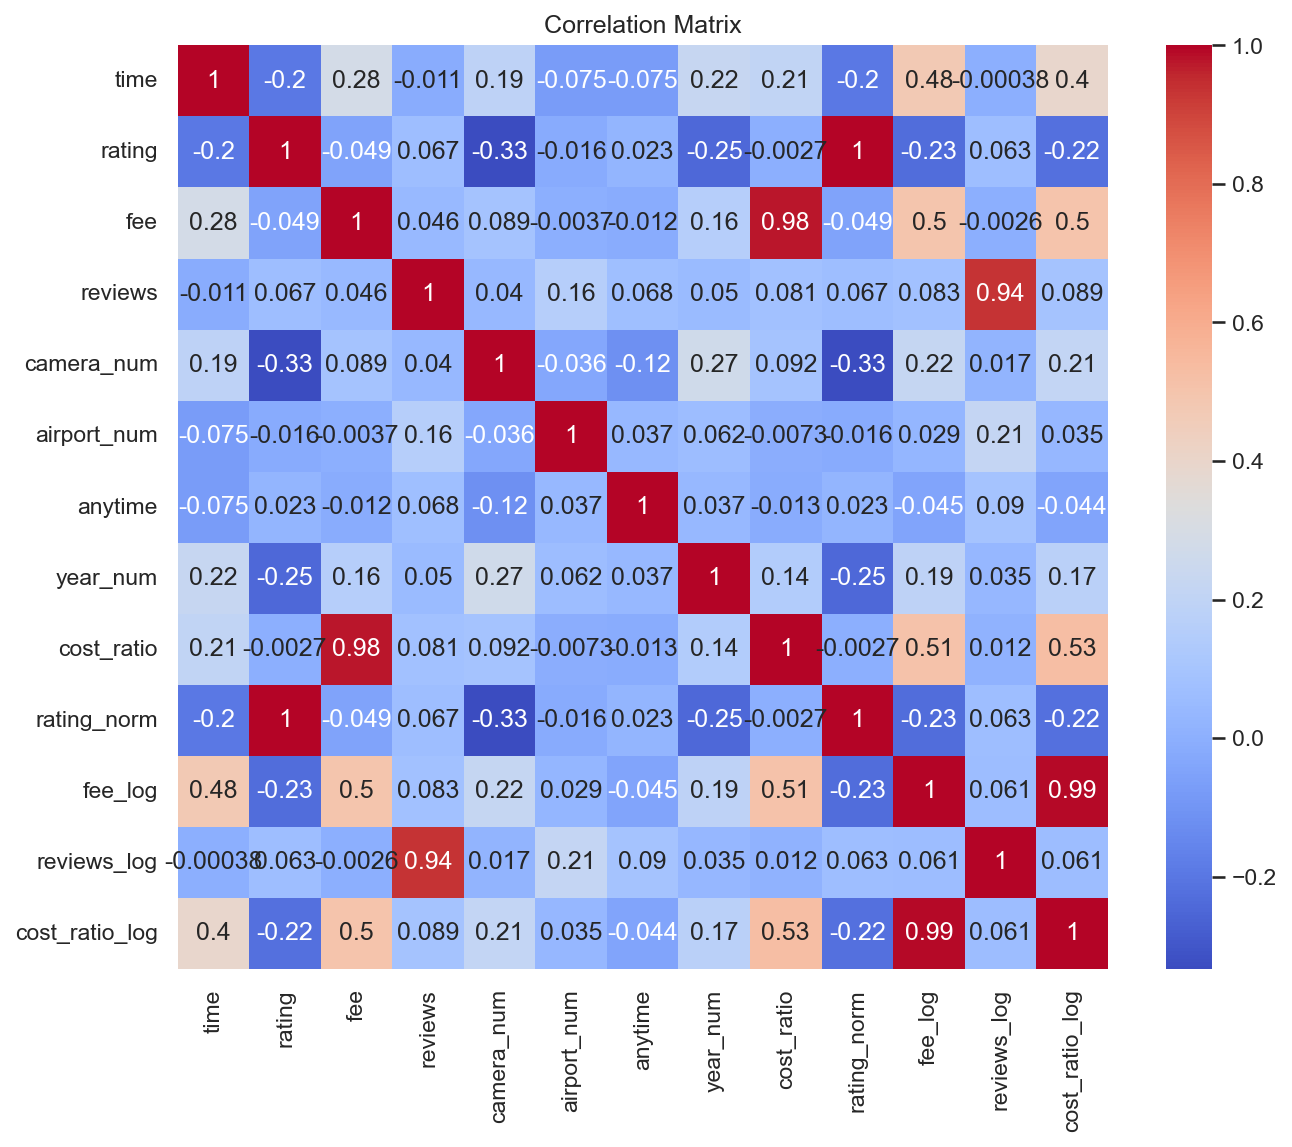

var_1           var_2      corr category  type
9              time         fee_log  0.475350     None  None
120         fee_log            time  0.475350     None  None
11             time  cost_ratio_log  0.395343     None  None
144  cost_ratio_log            time  0.395343     None  None
56       camera_num     rating_norm -0.333549     None  None
112     rating_norm      camera_num -0.333549     None  None
49       camera_num          rating -0.333549     None  None
15           rating      camera_num -0.333549     None  None

In [1526]:
corr_info()

In [2568]:
corr_total(df=df.drop(['rating_norm', 'reviews', 'fee', 'cost_ratio', 'camera_num', 'airport_num'], axis = 1), t_min = .6, f = 20)

var_1    var_2      corr      category          type
2  time  fee_log  0.659382          type          Fort
2  time  fee_log  0.649772          zone       Eastern
2  time  fee_log  0.634382  significance  Recreational
2  time  fee_log  0.619755          zone       Western

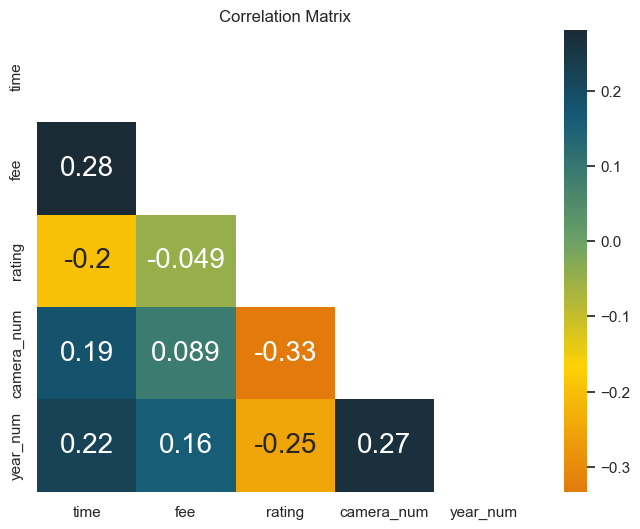

In [967]:
x = None
y = None
sns.set_theme(style="white")
cmap = load_cmap('Balistapus_undulatus', type='continuous', type_warning = False)

temp_df = df.drop(['rating_norm', 'reviews_log', 'fee_log', 'cost_ratio_log'], axis = 1)
temp_df = df[['time','fee','rating','camera_num','year_num']]

#Set plot size
plt.figure(figsize=(8,6))

#Create correlation matrix
corr_matrix_df = temp_df.corr(numeric_only = True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix_df)
mask[np.triu_indices_from(mask)] = True

#Convert correlation matrix to heatmap
sns.heatmap(corr_matrix_df, annot=True, cmap=cmap, mask=mask, annot_kws = {'size': 20}, center = 0)

#Set correlation matrix title
plt.title('Correlation Matrix')

#display correlation matrix
plt.show()

## Bivariate Analysis

In [735]:
def bivar_box(x, y, df=df, text='name', cat=None):
    """
    Display boxplots for discrete numerical categories.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    text : string, optional
        The hover name value for outlier points, default value = 'name'
    cat : string, optional
        Category by which to color code data, default value = None
    
    Returns
    -------
    
    Box plots for each discrete number category.
    
    """
    #filter outliers
    temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #create figure
    fig = px.box(temp_df, x=x, y=y, hover_name=text, color = cat, title = y + " vs " + x)

    return fig

def outliers(x, y, df=df):
    """
    Create dataframe of outliers based on category and type.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Dataframe of outliers.
    
    """

    #create outliers dataframe, remove NaNs
    outliers_df = df[[x, y]].dropna()

    #filter outliers from dataframe
    outliers_df = outliers_df.loc[~outliers_df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #merge filtered dataframe onto original dataframe
    outliers_df = outliers_df.merge(df, how = 'left', left_index = True, right_index = True, 
                              suffixes = ['', '_y'])[['name', x, y]].sort_values(by = y)
    
    return outliers_df

def bivar_sca(x, y, df=df, text = 'name', cat = None):
    """
    Display scatter plot for numerical categories.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    text : string, optional
        The hover name value for points, default value = 'name'
    cat : string, optional
        Category by which to color code data, default value = None
    
    Returns
    -------
    
    Scatter plot for numerical category.
    
    """
    #filter outliers
    temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #create figure
    fig = px.scatter(temp_df, x=x, y=y, color = cat, hover_name=text, title = y + " vs " + x)

    return fig


def bivariate(x, y, df=df, text = 'name', cat = None, type = 'sca'):
    """
    Display plot for numerical categories.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    text : string, optional
        The hover name value for points, default value = 'name'
    cat : string, optional
        Category by which to color code data, default value = None
    type : string, optional
        Type of plot to produce, default value = 'sca'
        Produce scatter plot : type = 'sca'
        Produce box plot : type = 'box'
    
    Returns
    -------
    
    Plot and outliers table.
    
    """

    #Display either scatter or box plot, depending on value of 'type'
    if type == 'sca':
        bivar_sca(x, y, df, text, cat).show()
    elif type == 'box':
        bivar_box(x, y, df, text, cat).show()
    #return outliers dataframe
    return display(outliers(x, y))
    


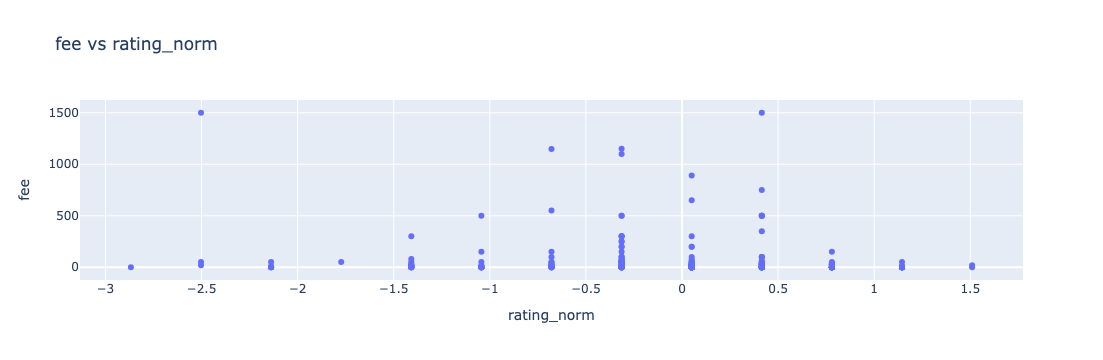

name  rating_norm   fee
26            Imagicaa   -11.256880  1149
47        Eden Gardens    -1.408513  2500
161   Paragliding Site     1.144767  2500
68   Gir National Park     0.050504  3500
72          Rann Utsav     1.509522  7500

In [739]:
bivariate('rating_norm', 'fee')

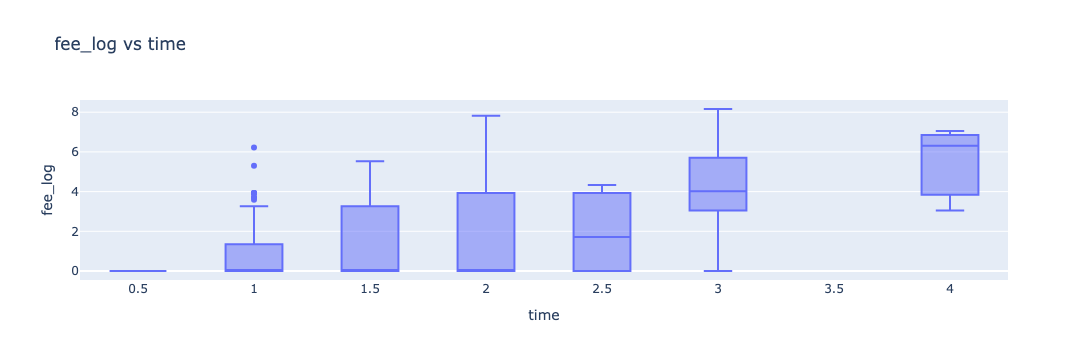

name  time   fee_log
162              Triund Trek   5.0  0.000000
200            Amarnath Cave   6.0  0.000000
198             Vaishno Devi   5.0  0.000000
2          Akshardham Temple   5.0  4.110874
15   National Science Centre   5.0  4.262680
180        Valley of Flowers   5.0  5.017280
78              Science City   7.0  6.216606
110  Wonderla Amusement Park   5.5  6.621406
24               Essel World   5.0  7.047517
26                  Imagicaa   5.0  7.047517
167          Kufri Fun World   5.0  7.313887
72                Rann Utsav   3.0  8.922792

In [745]:
bivariate('time', 'fee_log', type='box')

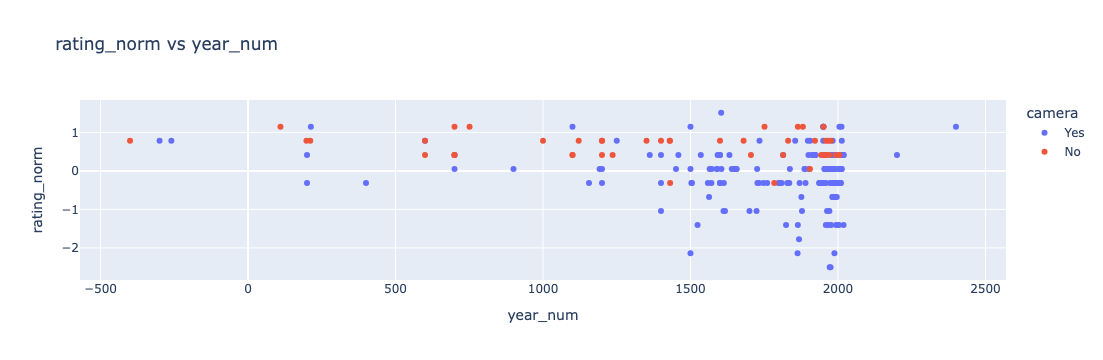

name  year_num  rating_norm
26                       Imagicaa    2013.0   -11.256880
229                 Barabati Fort    -987.0     0.050504
189                  Dhamek Stupa    -500.0     0.415259
136  Khajuraho Group of Monuments    -850.0     0.780013
174              Badrinath Temple    -820.0     1.144767
140     Mahakaleshwar Jyotirlinga   -3500.0     1.144767

In [135]:
bivariate('year_num', 'rating_norm', cat = 'camera')

In [119]:
loc = 0
f = 10
t_min = 0.8
t_max = 1
temp_df = df


temp_df = temp_df.drop(['anytime', 'camera_num', 'airport_num'], axis = 1)


temp_df = corr_total(t_min = t_min, t_max = t_max, f = f, df=temp_df)

temp_df = temp_df[temp_df['var_2'] != 'year_num']

#temp_df = temp_df[(temp_df['var_1'] == 'rating_norm') | (temp_df['var_2'] == 'rating_norm')]

#temp_df = temp_df.iloc[::2]

temp_df

var_1           var_2      corr      category           type
46        year_num         fee_log  0.996861         state            Goa
46        year_num         fee_log  0.996861          city            Goa
48        year_num  cost_ratio_log  0.996861         state            Goa
44        year_num      cost_ratio  0.996861         state            Goa
44        year_num      cost_ratio  0.996861          city            Goa
48        year_num  cost_ratio_log  0.996861          city            Goa
42        year_num             fee  0.996861         state            Goa
42        year_num             fee  0.996861          city            Goa
22             fee         reviews  0.932003         state  Uttar Pradesh
32         reviews             fee  0.932003         state  Uttar Pradesh
34         reviews      cost_ratio  0.930288         state  Uttar Pradesh
53      cost_ratio         reviews  0.930288         state  Uttar Pradesh
50      cost_ratio            time  0.922579          type      Waterfall
4             time      cost_ratio  0.922579          type      Waterfall
20             fee            time  0.914410          type      Waterfall
1             time             fee  0.914410          type      Waterfall
22             fee         reviews  0.912657          zone        Central
32         reviews             fee  0.912657          zone        Central
34         reviews      cost_ratio  0.911177          zone        Central
53      cost_ratio         reviews  0.911177          zone        Central
20             fee            time  0.887118  significance   Recreational
1             time             fee  0.887118  significance   Recreational
40        year_num            time  0.861293          city            Goa
40        year_num            time  0.861293         state            Goa
20             fee            time  0.844814         state         Kerala
1             time             fee  0.844814         state         Kerala
70         fee_log            time  0.832759          type      Waterfall
6             time         fee_log  0.832759          type      Waterfall
90  cost_ratio_log            time  0.817473          type      Waterfall
8             time  cost_ratio_log  0.817473          type      Waterfall
20             fee            time  0.801774         state     Maharastra
1             time             fee  0.801774         state     Maharastra
41        year_num          rating -0.980883          type           Lake
45        year_num     rating_norm -0.980883          type           Lake

city
Goa
0


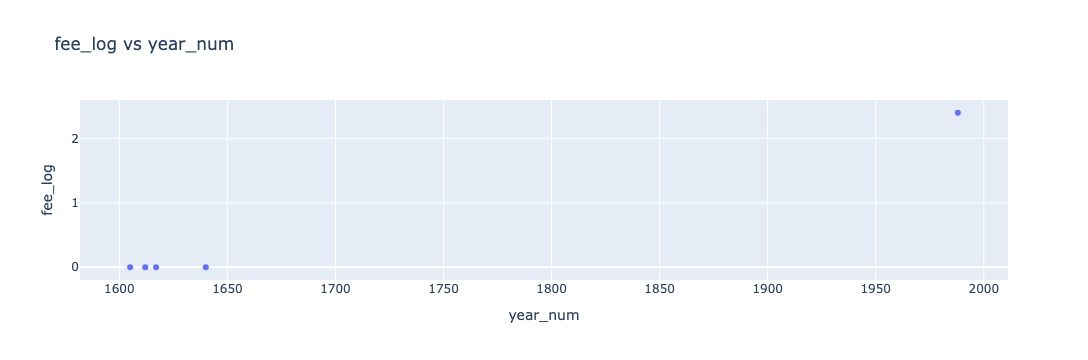

state
Goa
1


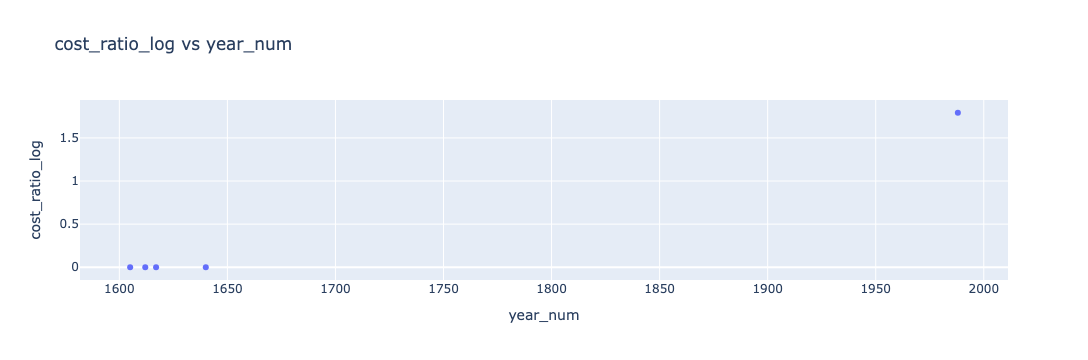

city
Goa
2


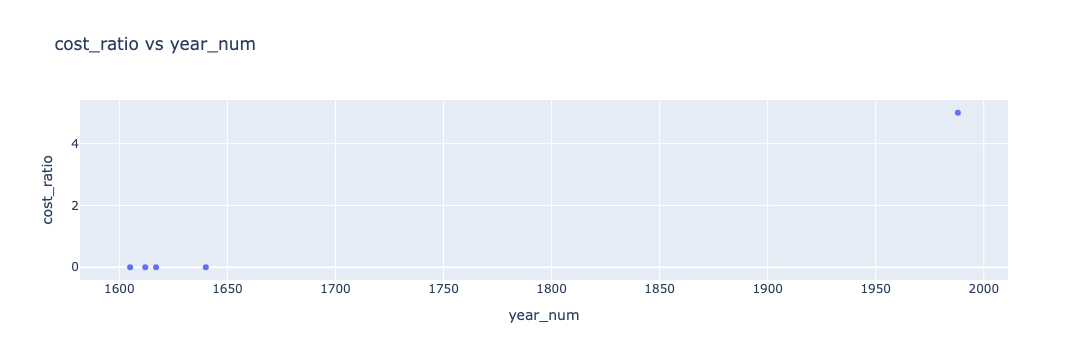

state
Goa
3


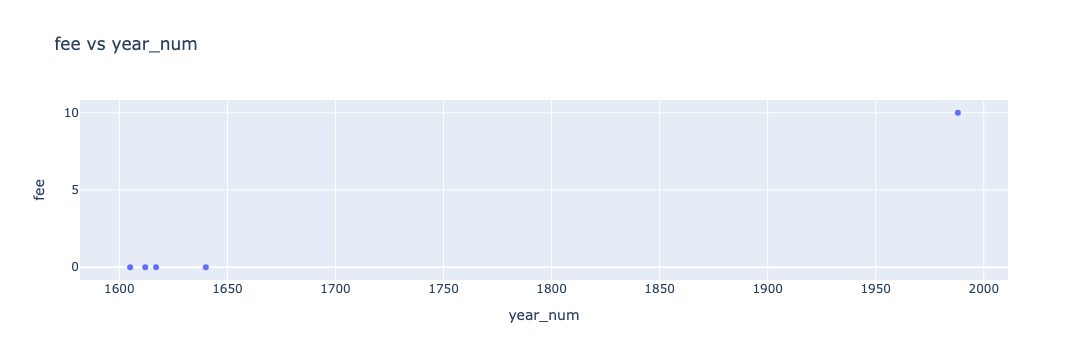

state
Uttar Pradesh
4


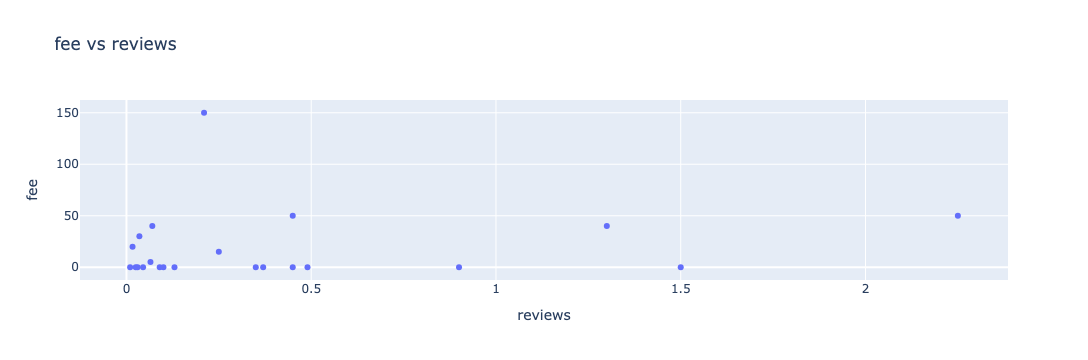

state
Uttar Pradesh
5


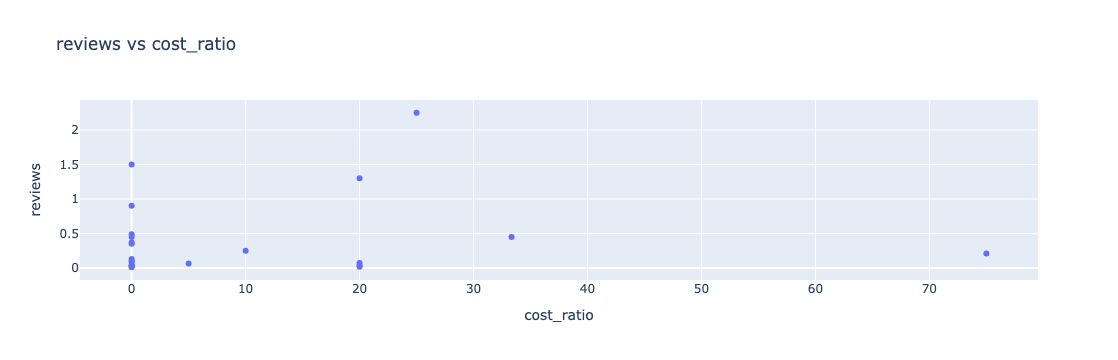

type
Waterfall
6


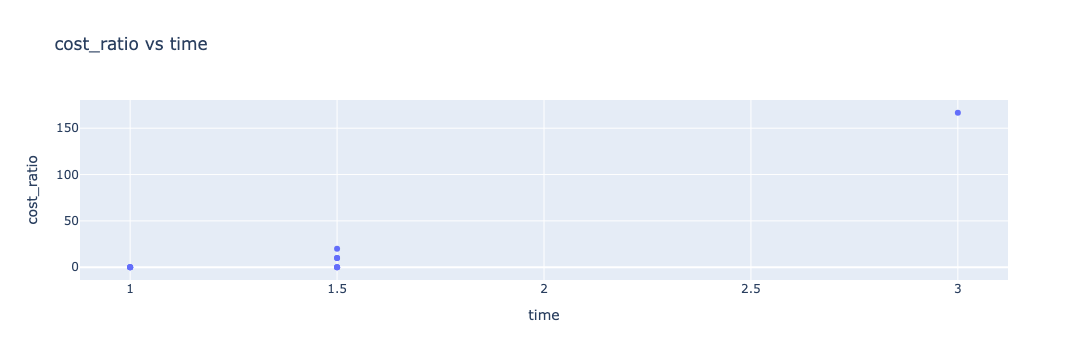

type
Waterfall
7


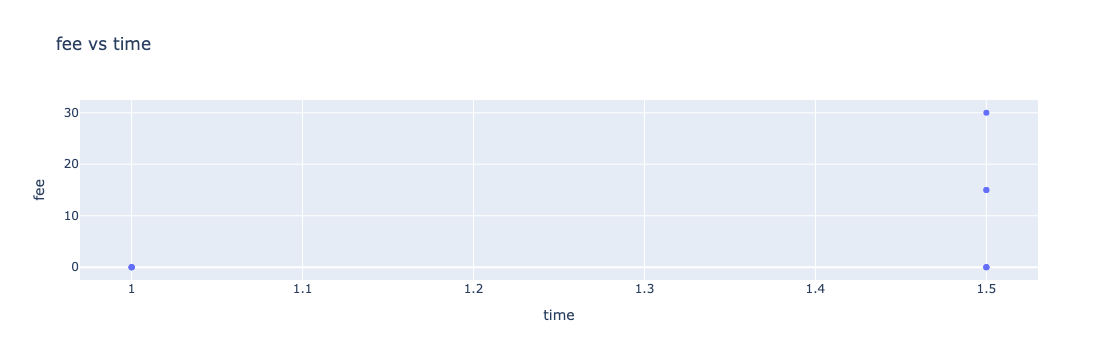

zone
Central
8


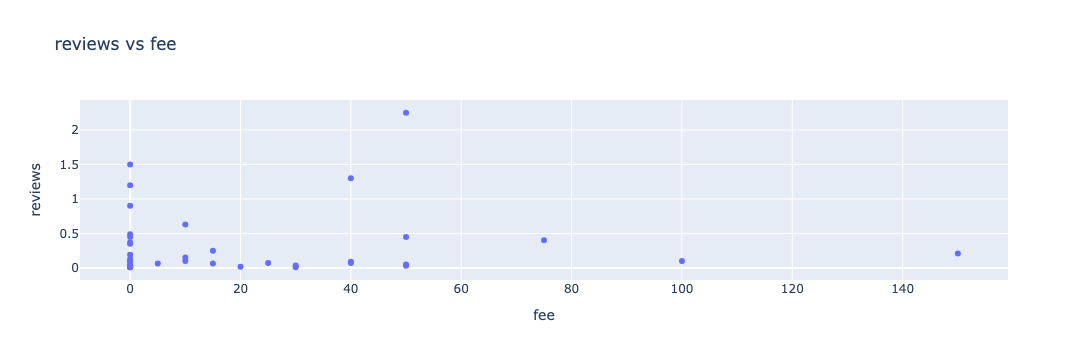

zone
Central
9


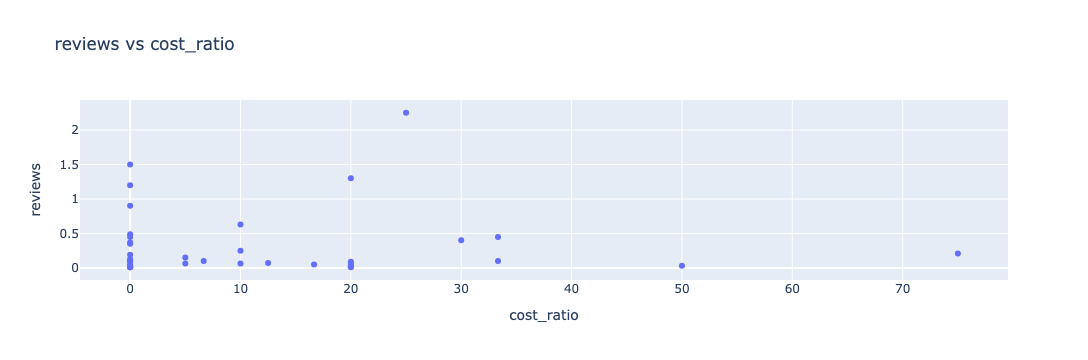

significance
Recreational
10


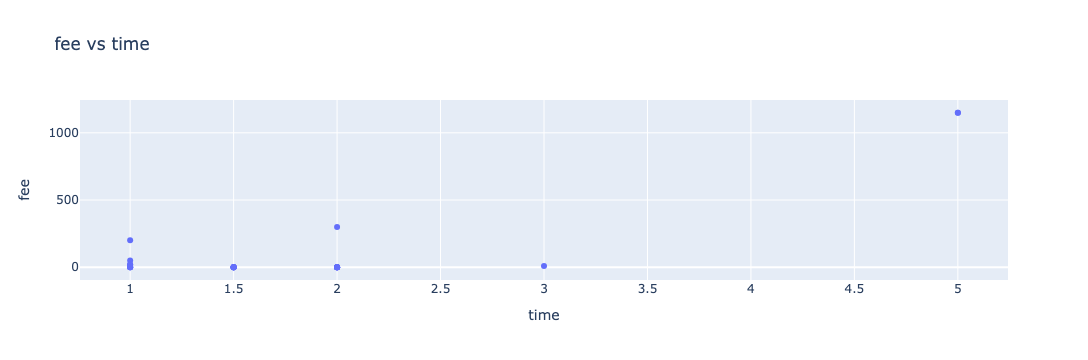

city
Goa
11


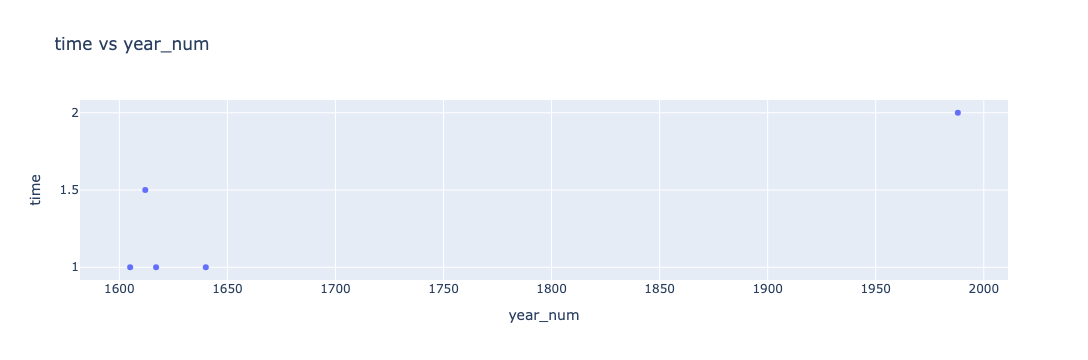

state
Kerala
12


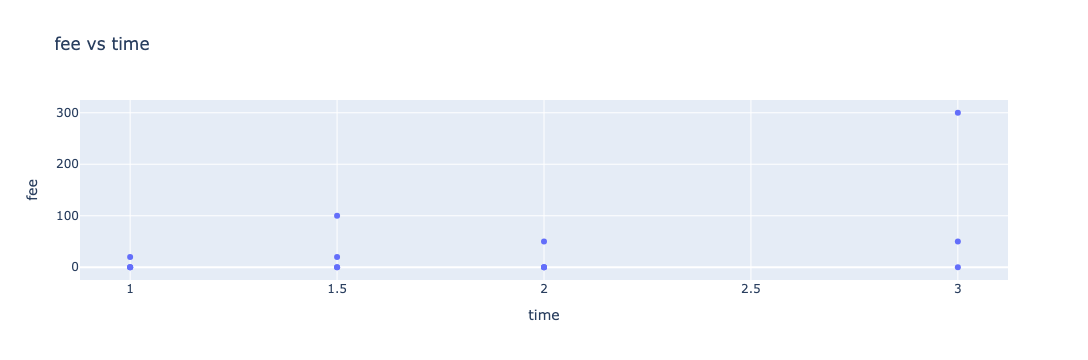

type
Waterfall
13


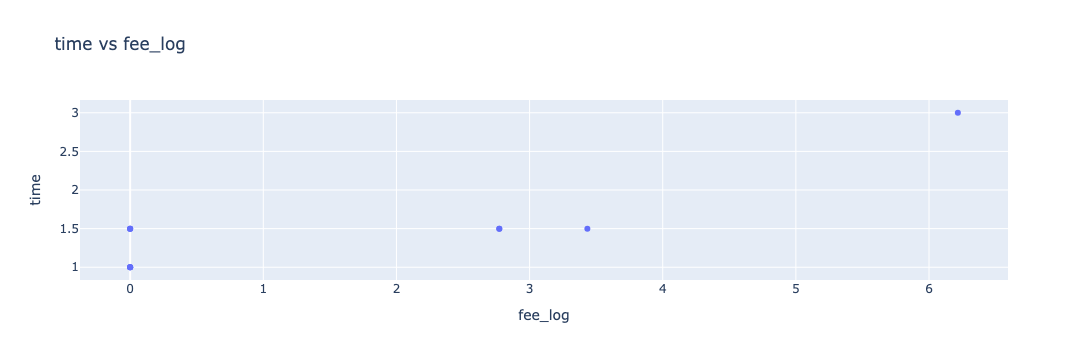

type
Waterfall
14


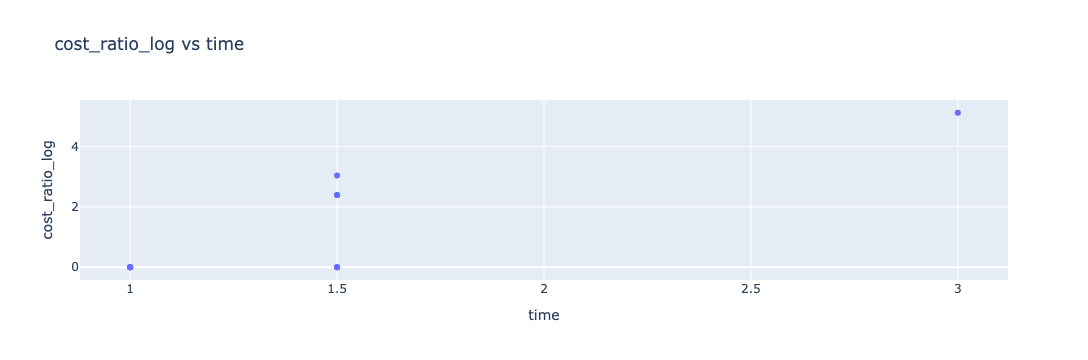

state
Maharastra
15


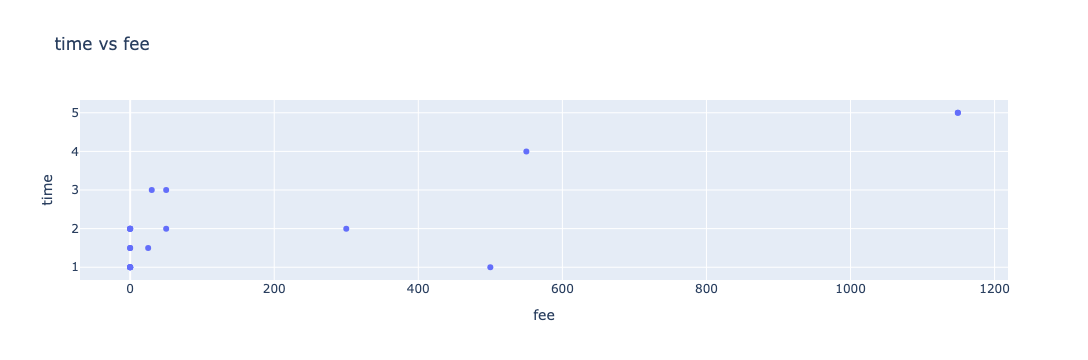

state
Uttar Pradesh
16


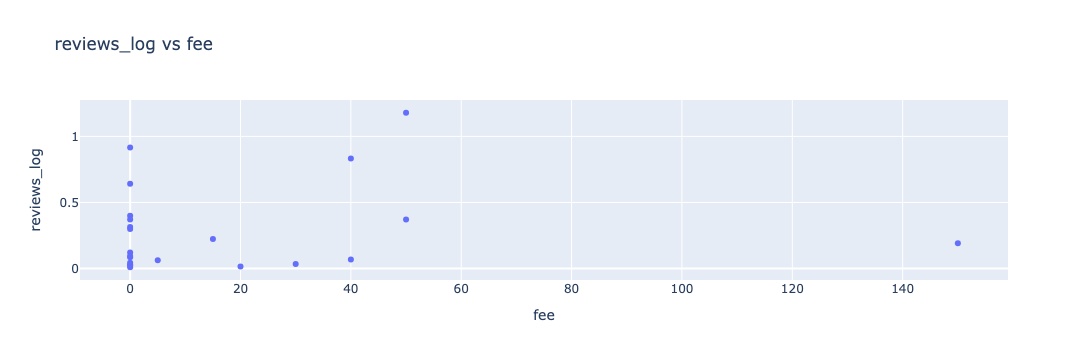

state
Uttar Pradesh
17


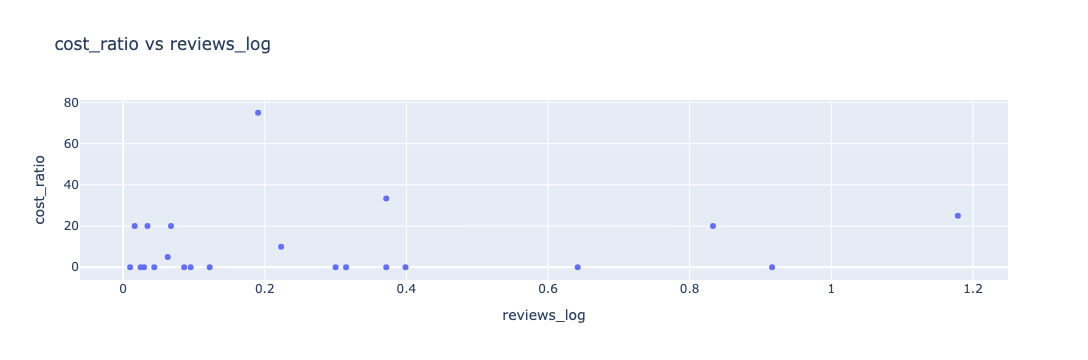

state
Rajasthan
18


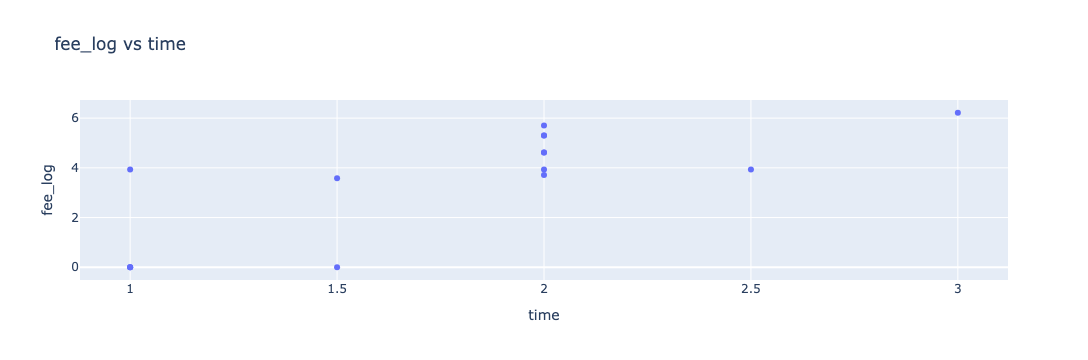

city
Hyderabad
19


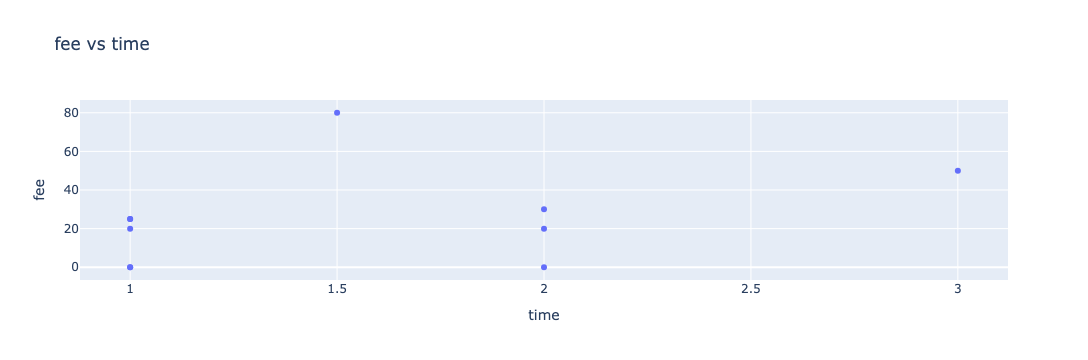

state
Telangana
20


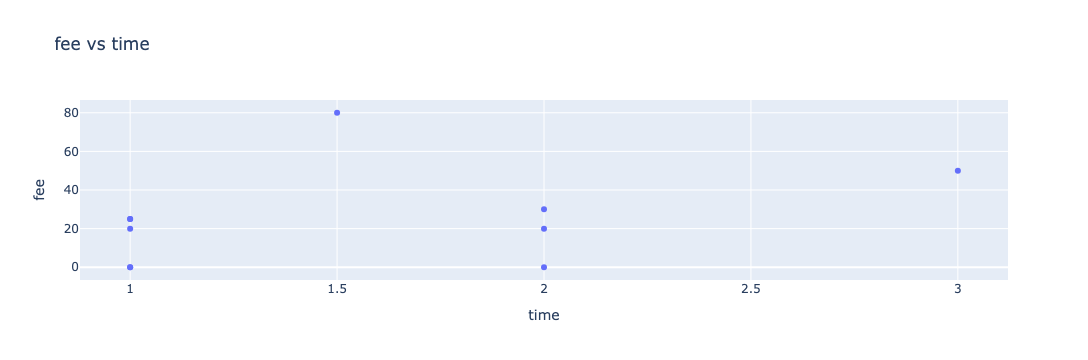

type
Palace
21


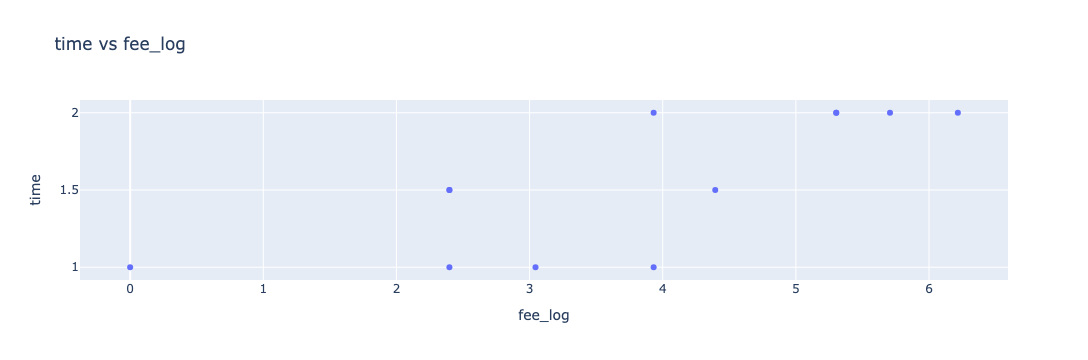

state
West Bengal
22


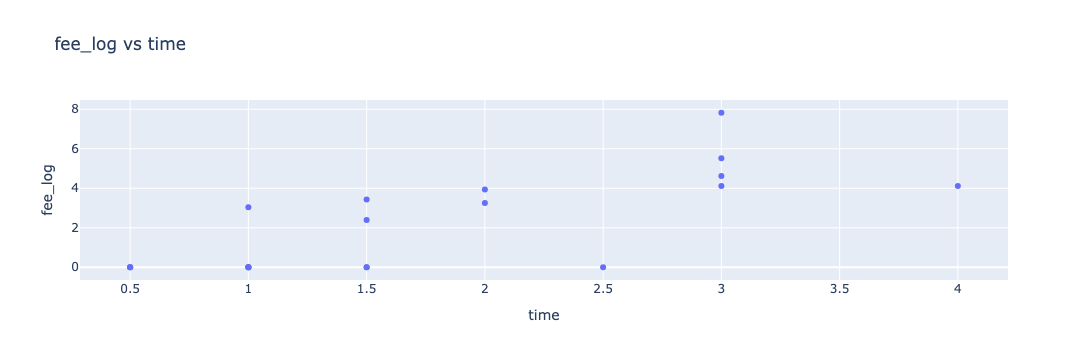

state
Madhya Pradesh
23


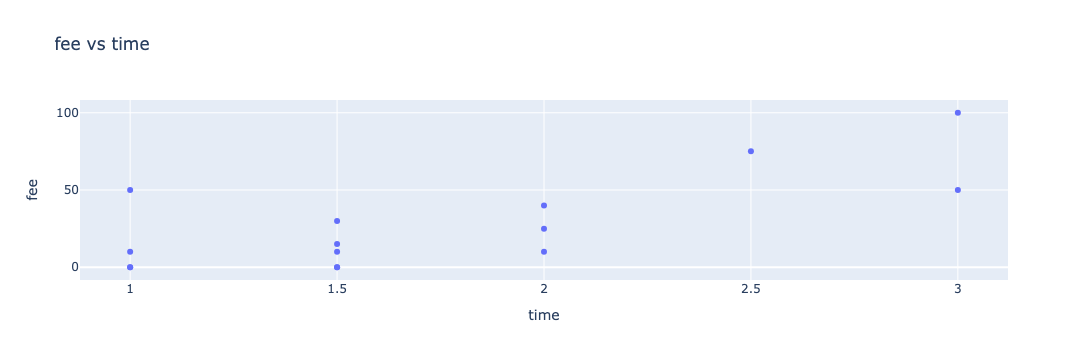

significance
Recreational
24


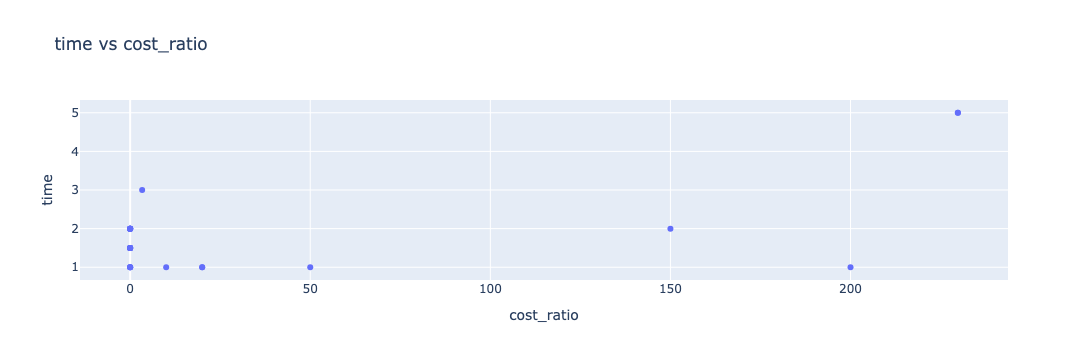

city
Hyderabad
25


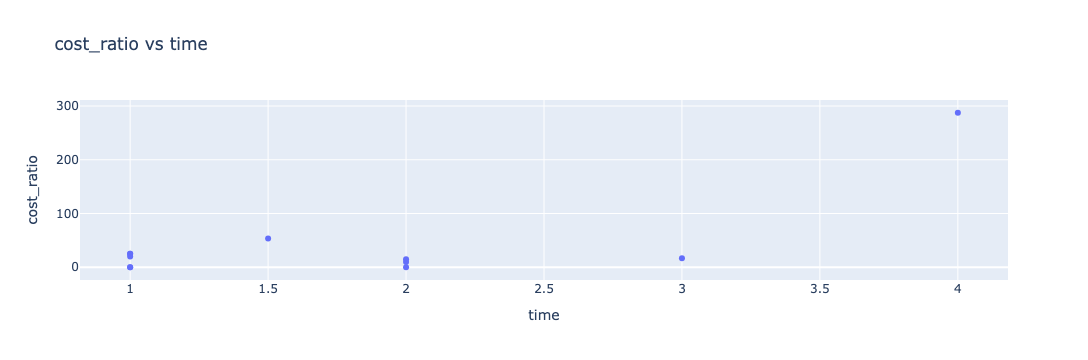

state
Telangana
26


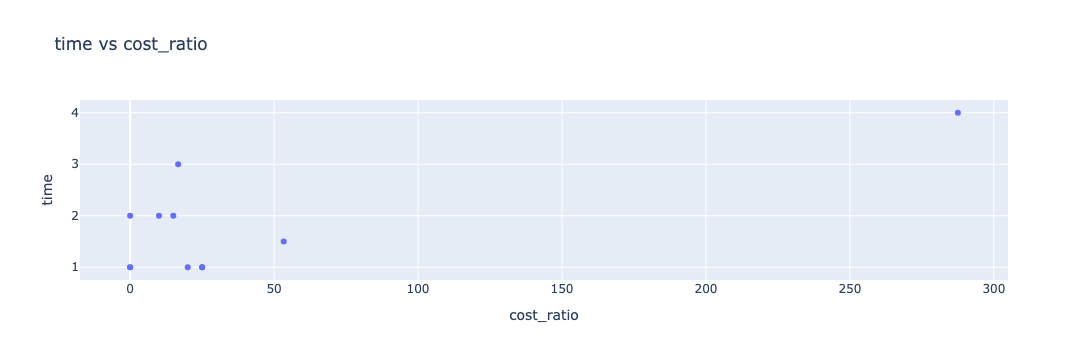

state
Kerala
27


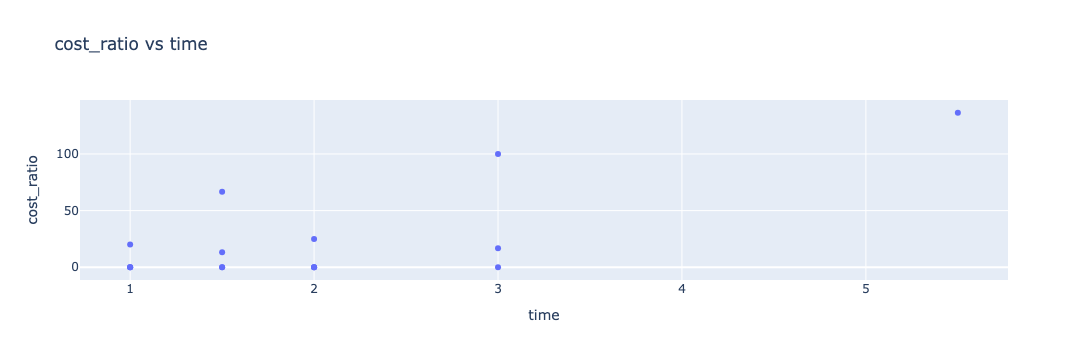

zone
Central
28


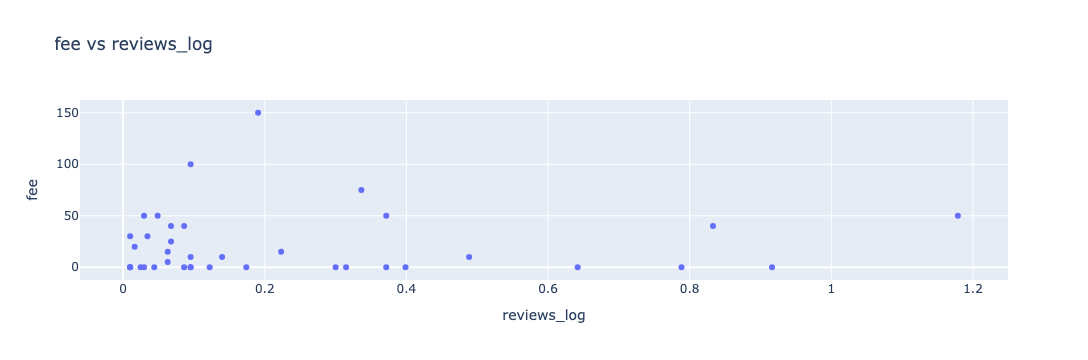

zone
Central
29


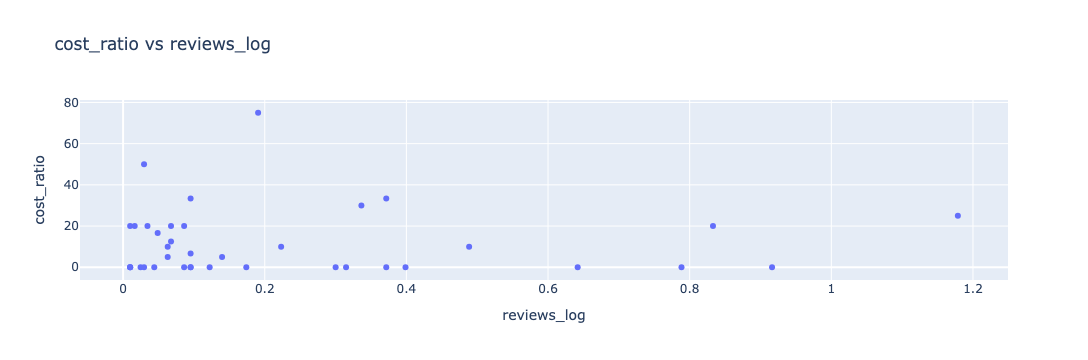

state
Rajasthan
30


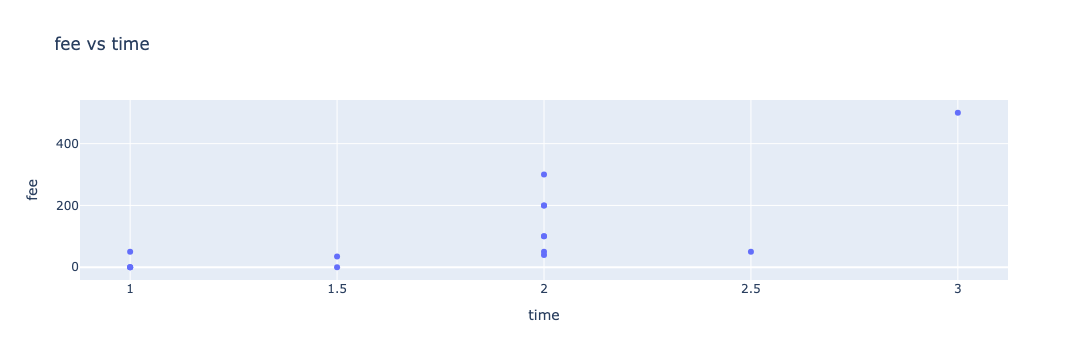

state
Maharastra
31


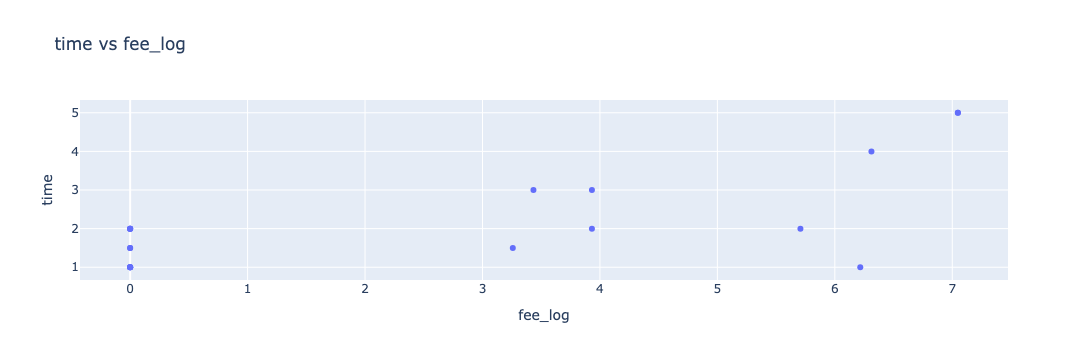

state
Rajasthan
32


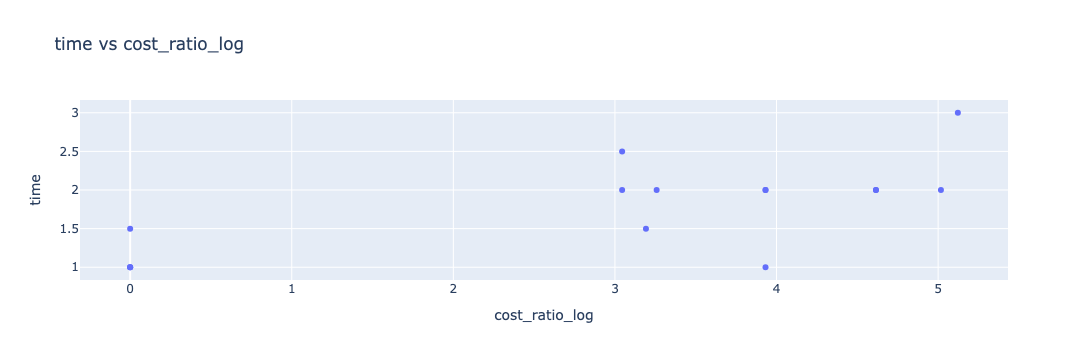

state
Andhra Pradesh
33


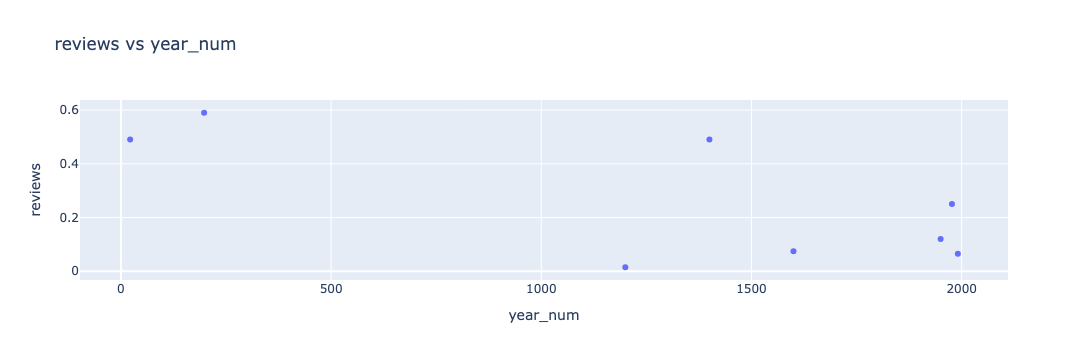

type
Palace
34


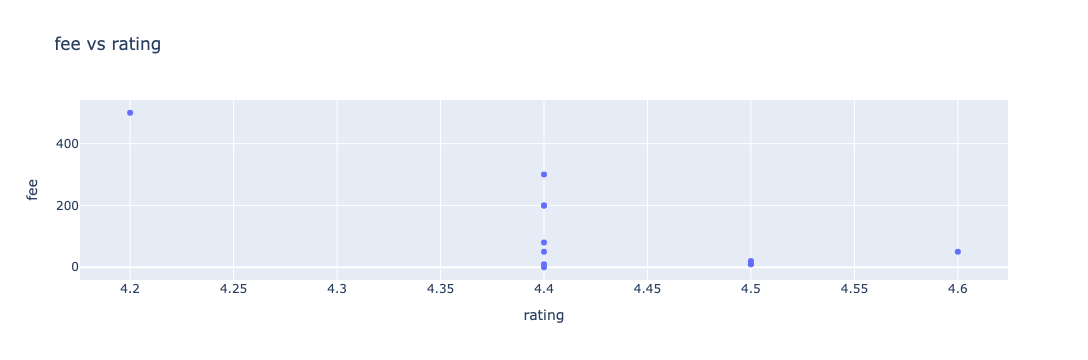

type
Palace
35


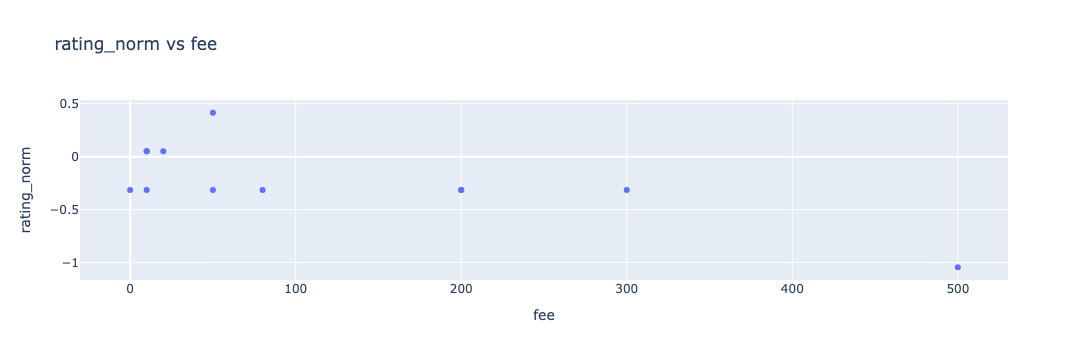

type
Palace
36


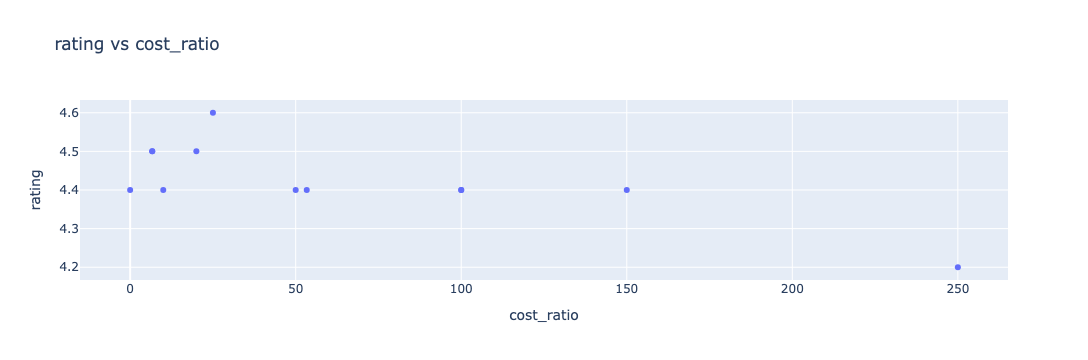

type
Palace
37


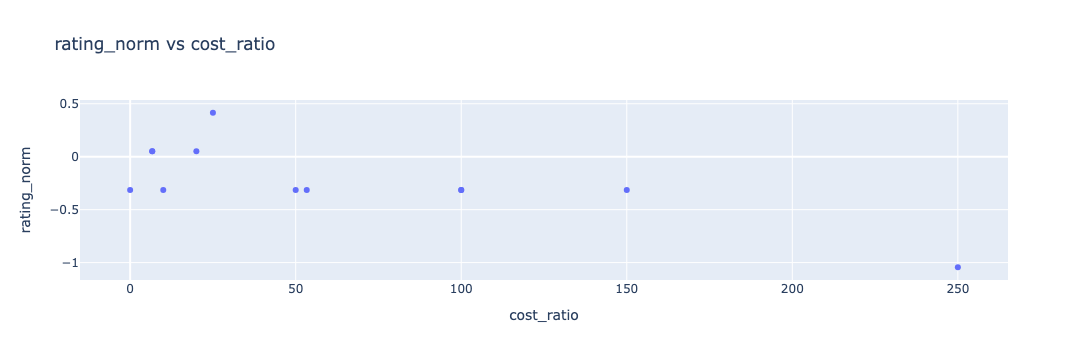

city
Goa
38


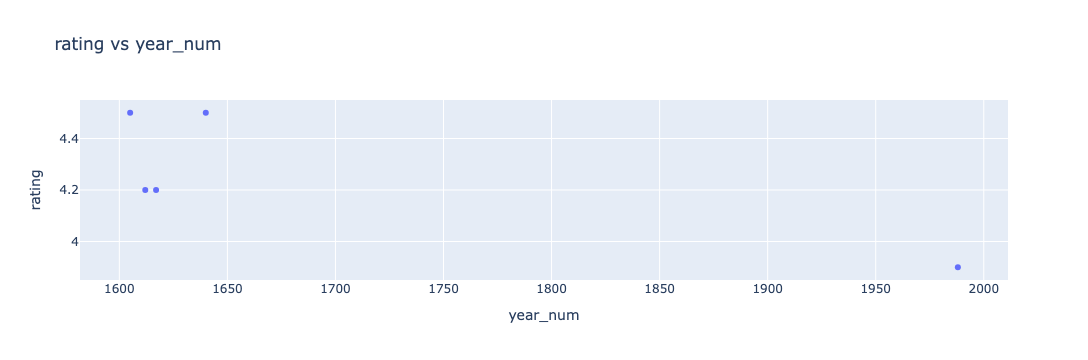

state
Goa
39


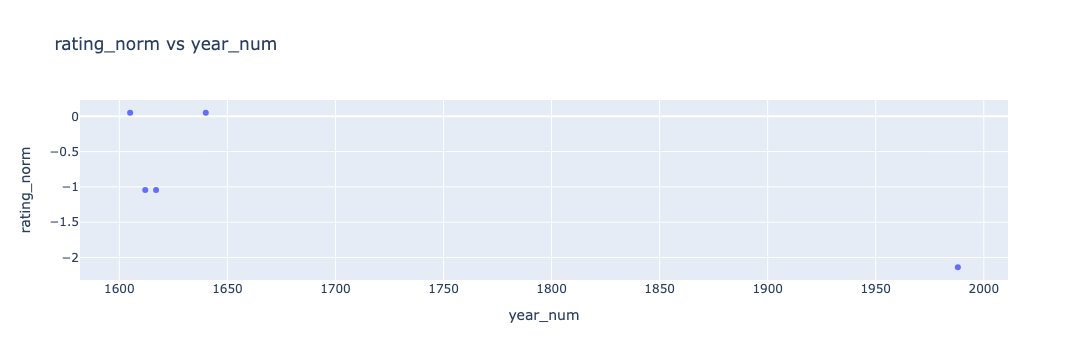

type
Lake
40


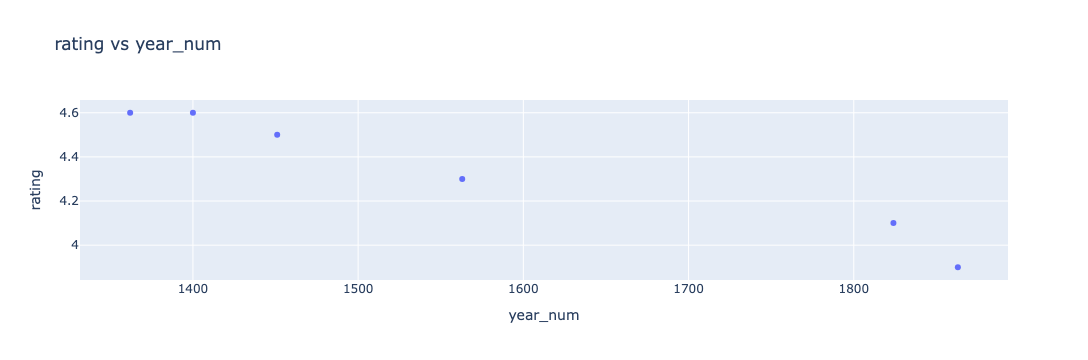

In [426]:
loc = 0

for loc in range(0, len(temp_df)):
    var_1, var_2, corr, category, type = temp_df.iloc[loc]
    print(category)
    print(type)
    print(loc)
    display(bivar_sca(var_1, var_2, df = df[df[category] == type]))
    loc += 1

Categorical analysis

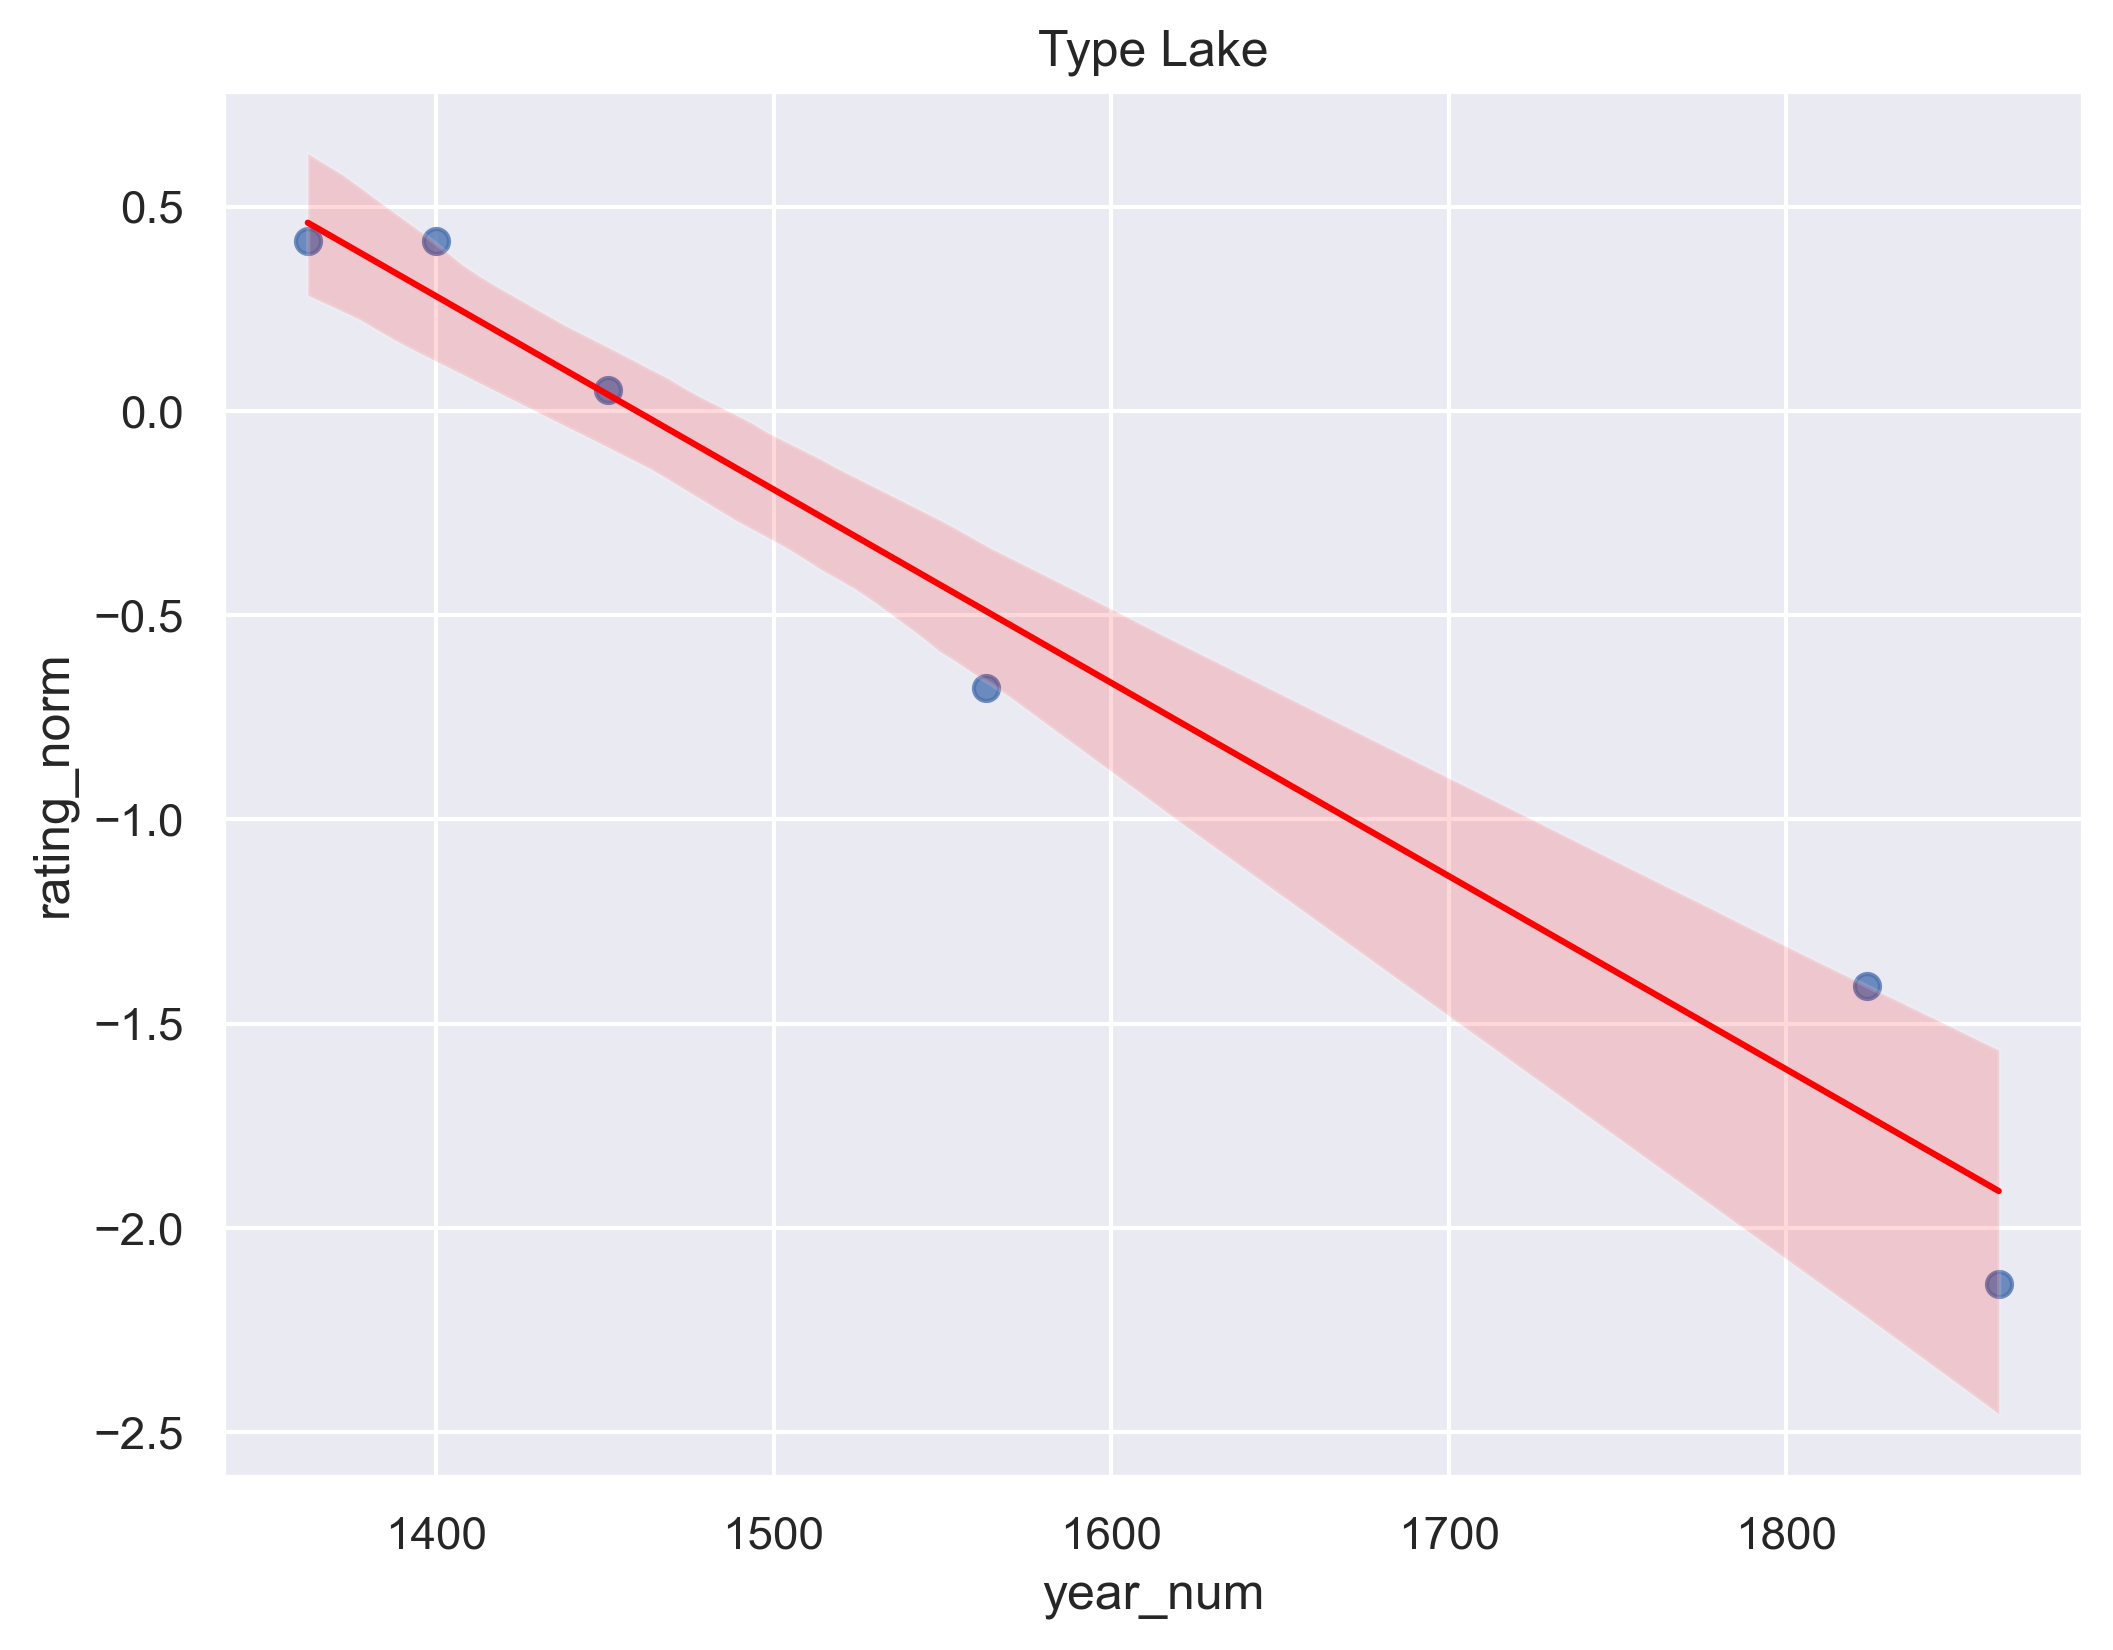

In [2674]:
fig, ax = plt.subplots(figsize=(8, 6))

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
temp_df= temp_df[temp_df['type'] == 'Lake']

sns.regplot(
    x=temp_df["year_num"],
    y=temp_df["rating_norm"],
    line_kws={"color": "red", "linewidth": 1.5},
    ax=ax,
).set(title='Type Lake')
plt.savefig("Lake.png")
plt.show()


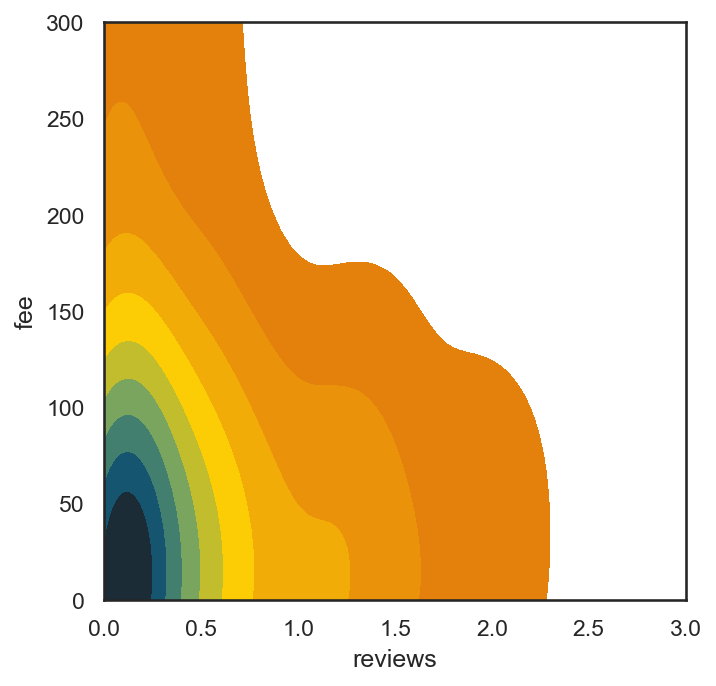

In [1530]:
x='reviews'
y='fee'
cmap = load_cmap('Balistapus_undulatus', type='continuous', type_warning = False)
temp_df = df
temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

sns.set_style("white")
sns.kdeplot(x=temp_df[x], y=df[y], cmap=cmap, fill=True)
plt.ylim(0, 300)
plt.xlim(0, 3)
plt.show()

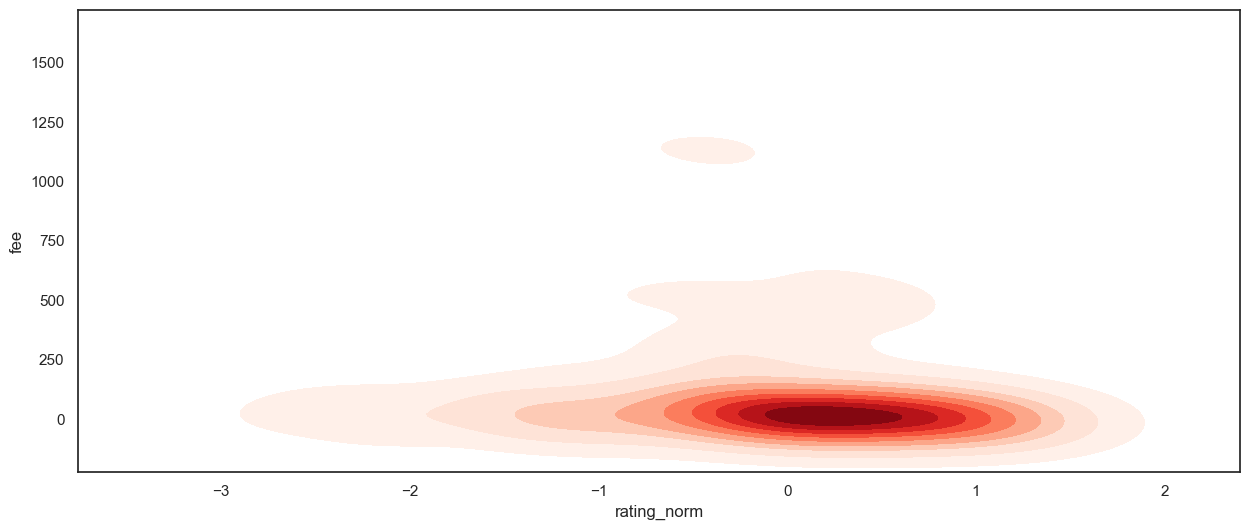

In [951]:
x='rating_norm'
y='fee'
temp_df = df
temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

sns.set_style("white")
sns.kdeplot(x=temp_df[x], y=df[y], cmap='Reds', fill=True)
#plt.ylim(0, 1300)
plt.show()

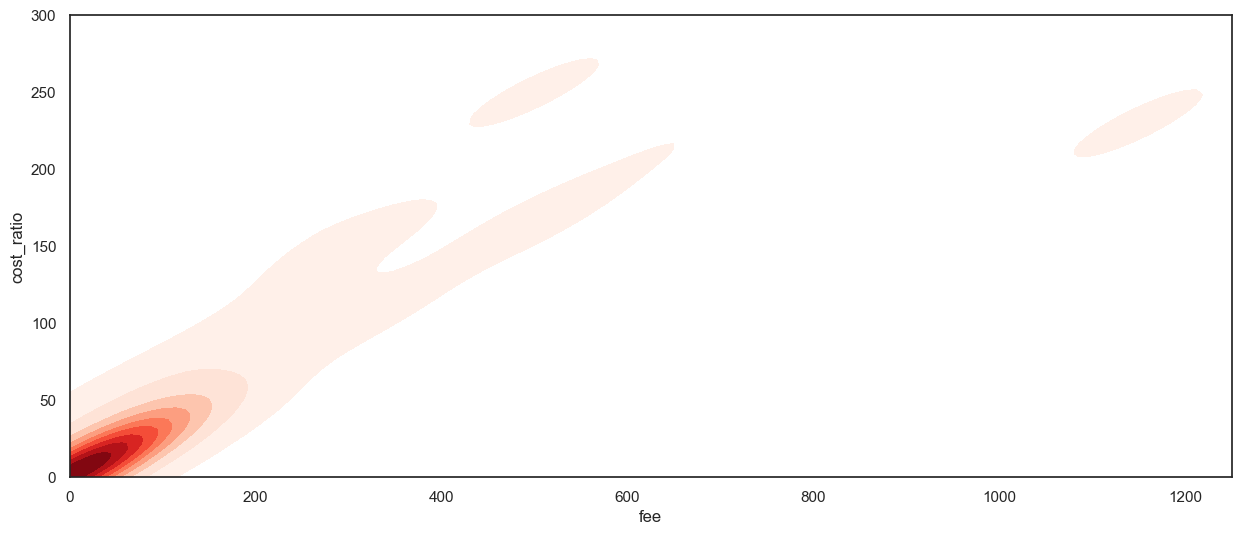

In [927]:
y='cost_ratio'
x='fee'
temp_df = df
temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

sns.set_style("white")
sns.kdeplot(x=temp_df[x], y=df[y], cmap='Reds', fill=True)
plt.ylim(0, 300)
plt.xlim(0, 1250)
plt.show()

## Categorical Analysis

In [539]:
def cat_hist(x, df=df):
    """
    Create bar chart showing count of each type within variable x.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Bar chart of count.
    
    """
    #filter dataframe on elements with count greater than 3
    temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3)

    #create figure
    fig = px.histogram(temp_df, x=x).update_xaxes(categoryorder="total descending")

    return fig


def cat_bar(x, y, df=df):
    """
    Create bar chart showing average value of each type y within variable x.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the numerical element for bar value.
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Bar chart of average y-value.
    
    """
    #filter dataframe on elements with count greater than 3. Compute mean y value of each type.
    temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    x, observed = False)[[y]].mean().sort_values(y, ascending = False).dropna()

    #create figure
    fig = px.bar(temp_df, y=y)

    #plot settings
    fig.update_layout(
        title="Average rating for each "+ x + " category",
        xaxis_title="",
        yaxis_title=y,)

    return fig

def cat_ttest(x, y, df=df):
    """
    Perform 1-sample t-test on y value of each x variable type.
    Produce a dataframe of the significant types.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y ; string
        The name of the numerical element to compute tests.
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Dataframe of significant types.
    
    """
    #create empty lists
    cat_lst = []
    p_lst = []

    #filter dataframe on elements with count greater than 3. Compute mean y value of each type.
    temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    x, observed = False)[[y]].mean().sort_values(y, ascending = False).dropna()

    #perform t-test on mean y of each x category.
    for category in temp_df.index:
        p = sp.stats.ttest_1samp(df[df[x] == category][y], df[y].mean())[1]
        if p < 0.05:
            cat_lst.append(category)
            p_lst.append(p)

    #combine lists into dataframe
    p_df = pd.DataFrame(list(zip(cat_lst, p_lst)), columns = ['category', 'p-value'])

    #Do not return empty dataframe
    if p_df.empty:
        pass
    else:
        return p_df
        


def categorical(x, y, df=df):
    """
    Produce bar chart of counts.
    Produce bar chart of average y value.
    Display ANOVA stats
    Display t-test dataframe.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y ; string
        The name of the numerical element to compute tests.
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Bar chart of counts.
    Bar chart of average y value.
    ANOVA stats
    t-test dataframe
    
    """

    cat_hist(x, df=df).show()
    
    cat_bar(x, y, df=df).show()
    
    print(pg.anova(data=df, dv=y, between=x))
    
    temp_df = cat_ttest(x, y, df=df)
    
    
    return #temp_df

In [ ]:
df[df['

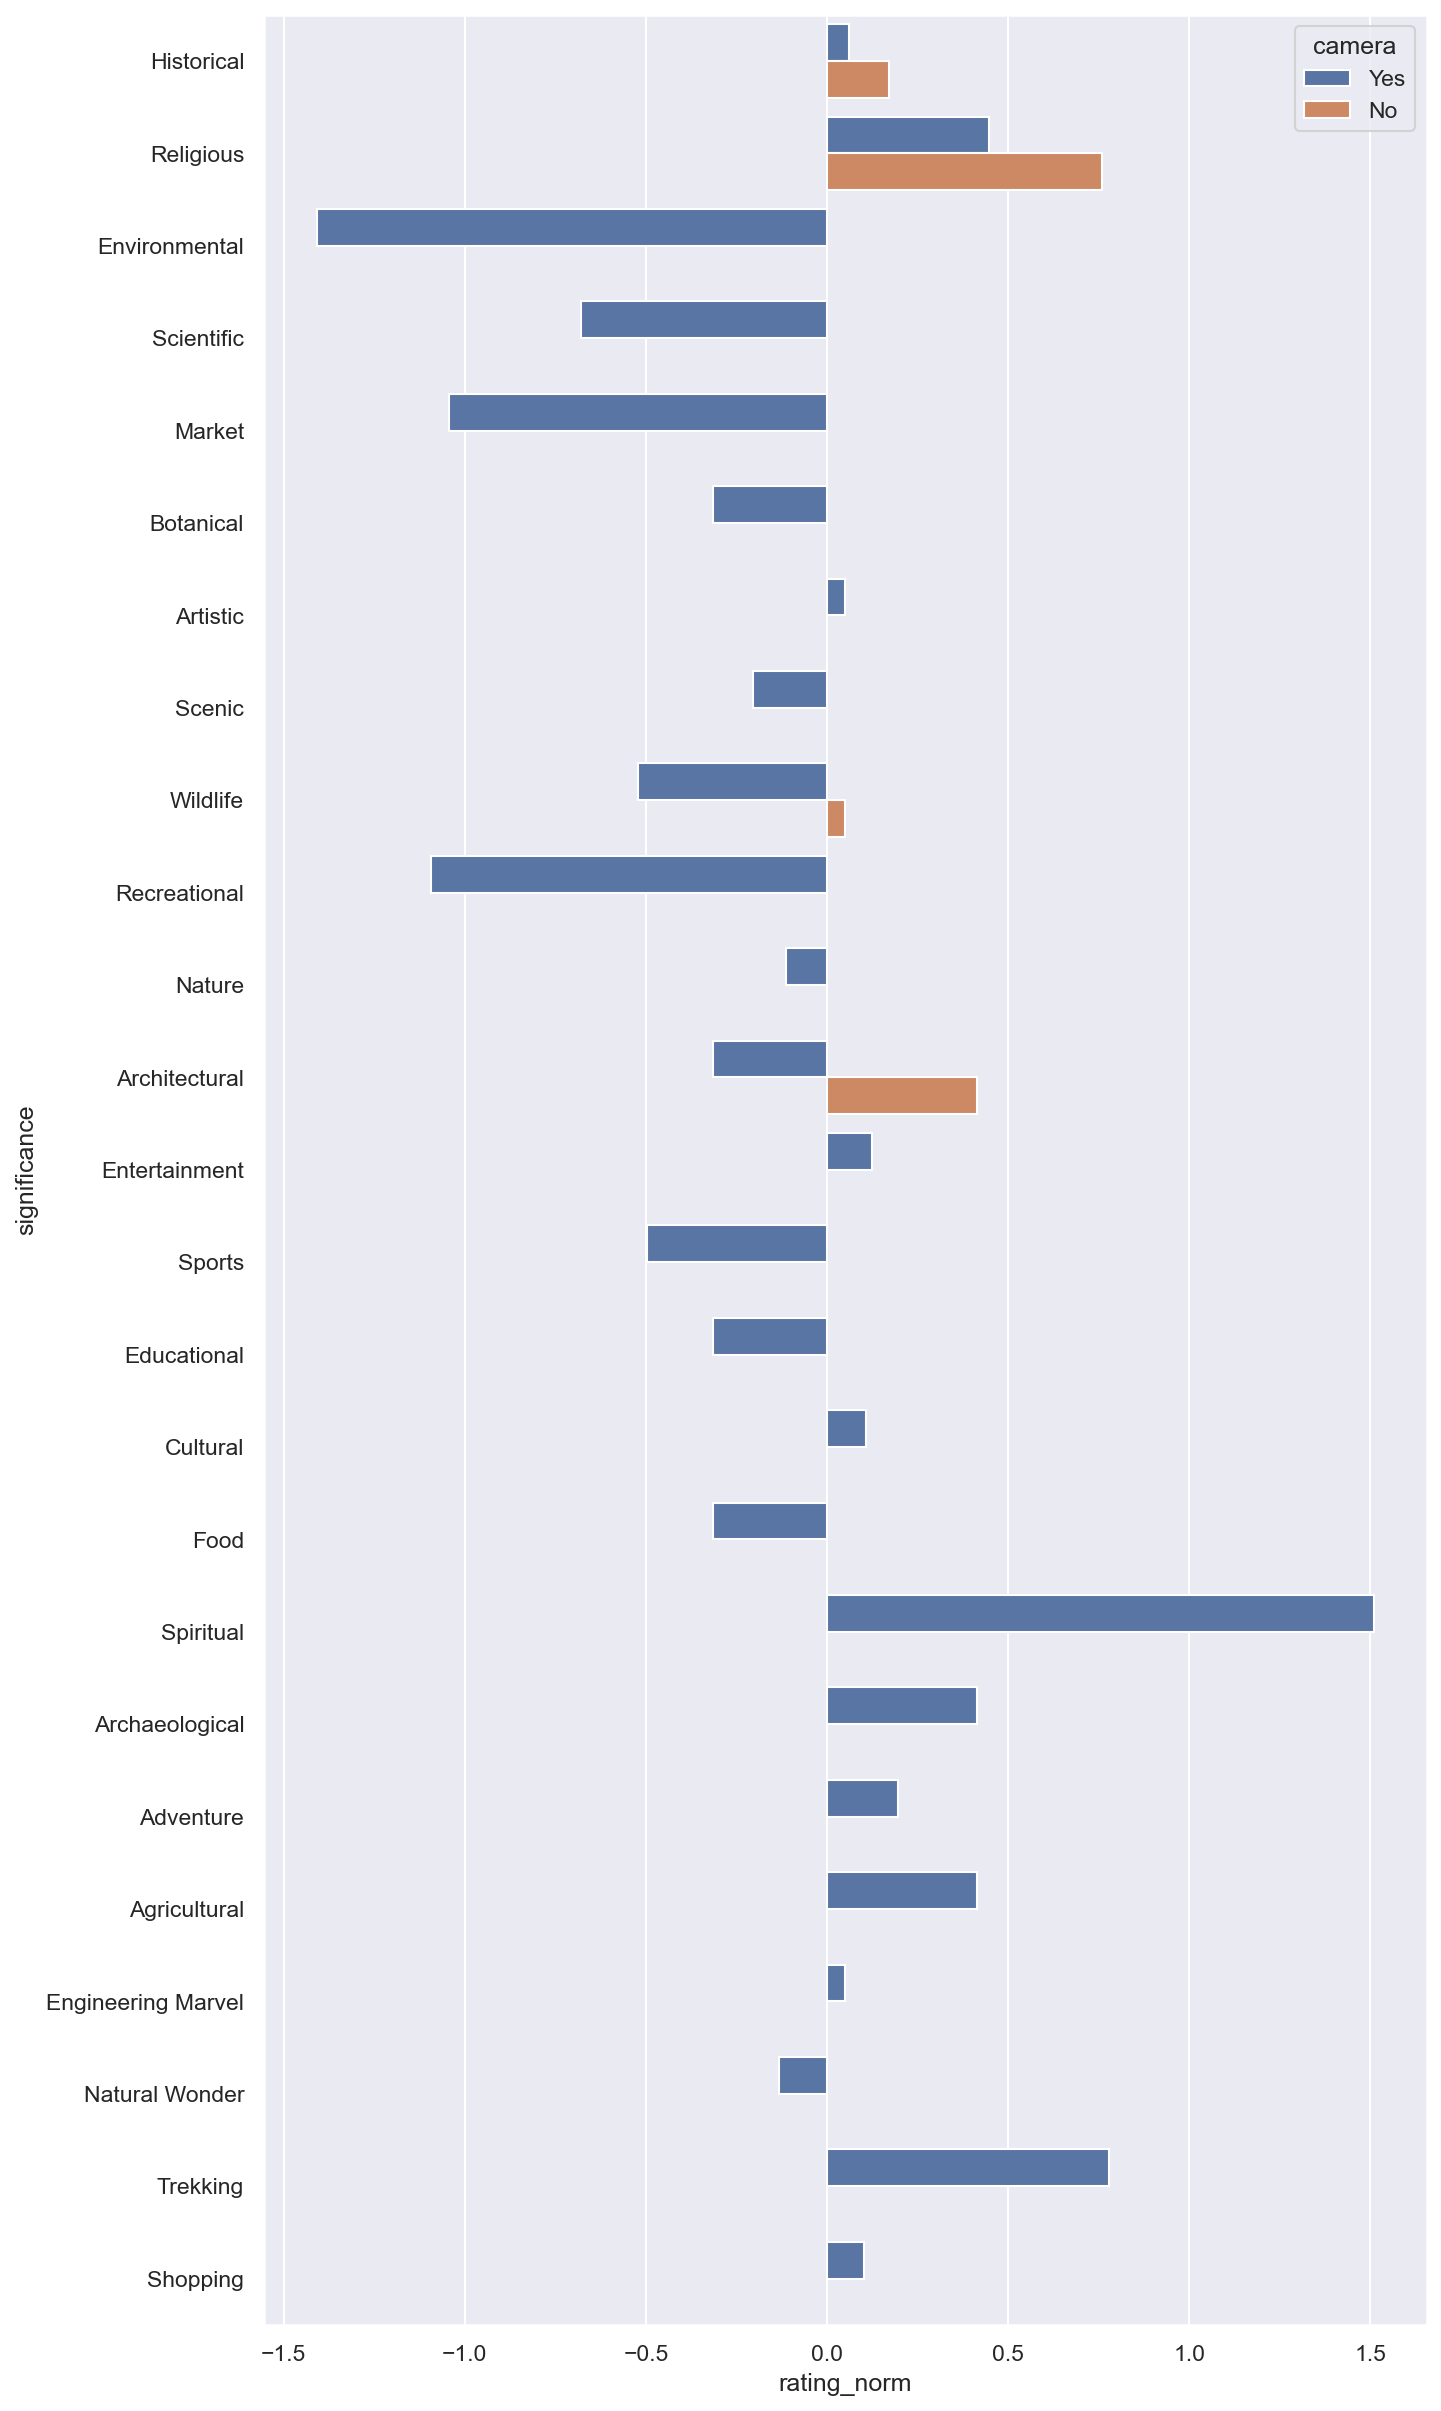

In [1584]:
sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(y='significance', x='rating_norm', hue='camera', data=df, errorbar=None, orient = 'h');

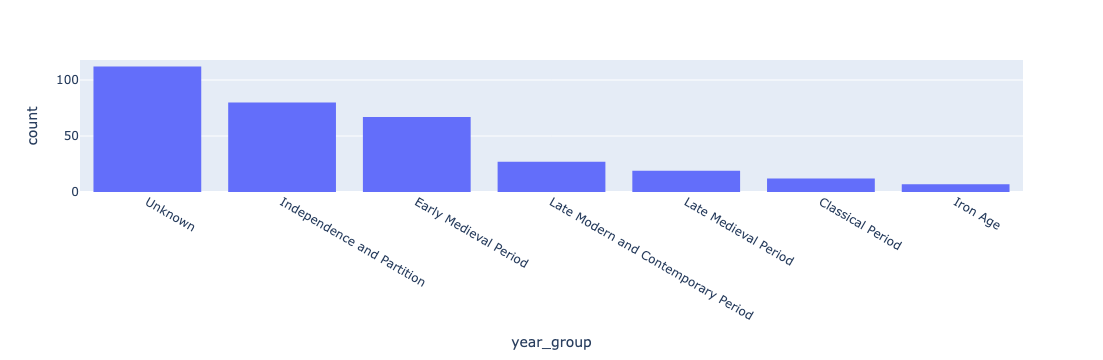

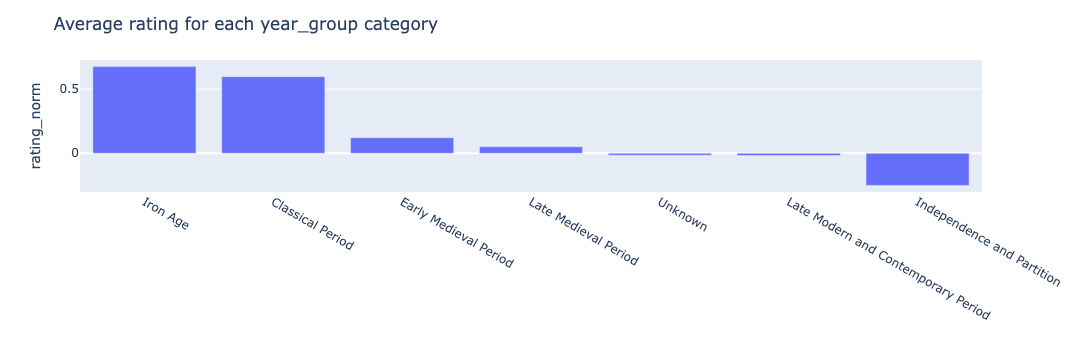

       Source  ddof1  ddof2         F     p-unc       np2
0  year_group      7    317  2.172245  0.036403  0.045772


category   p-value
0          Iron Age  0.002108
1  Classical Period  0.001736

In [461]:
categorical('year_group', 'rating_norm')

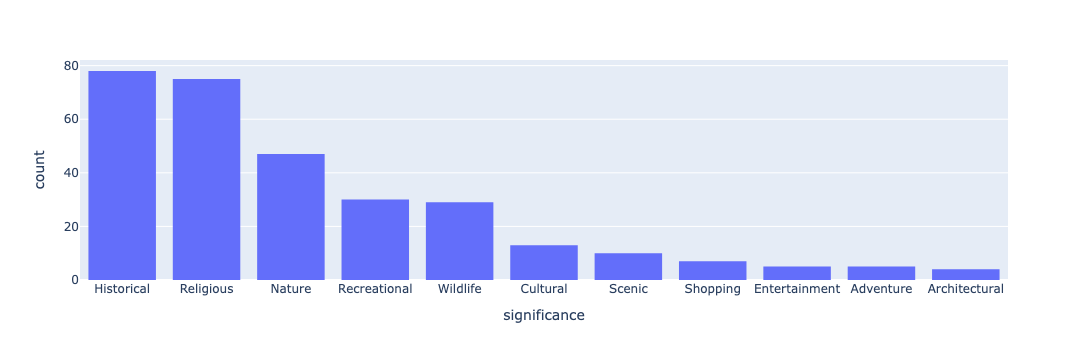

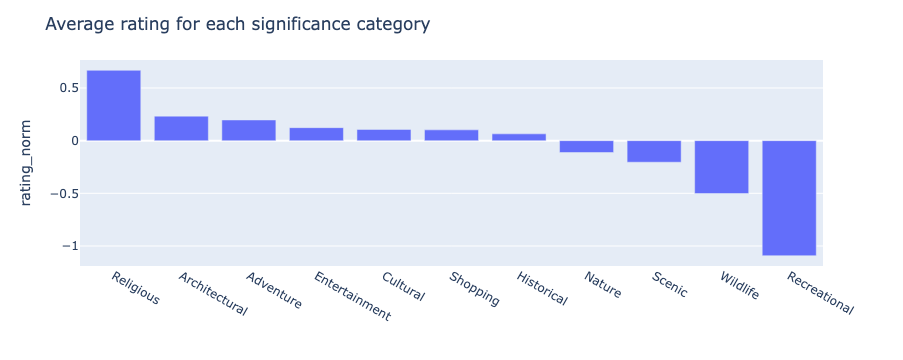

         Source  ddof1  ddof2         F         p-unc       np2
0  significance     24    300  4.714182  3.796962e-11  0.273855


category       p-value
0     Religious  5.739242e-24
1      Wildlife  3.100008e-04
2  Recreational  9.313066e-03

In [241]:
categorical('significance', 'rating_norm')

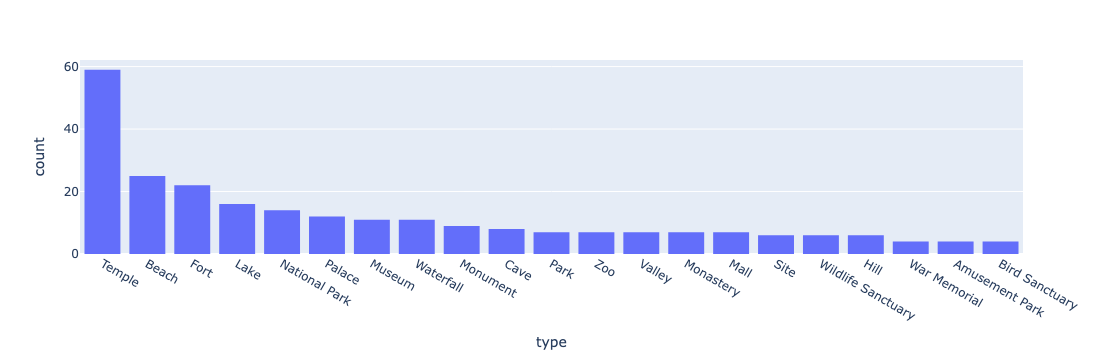

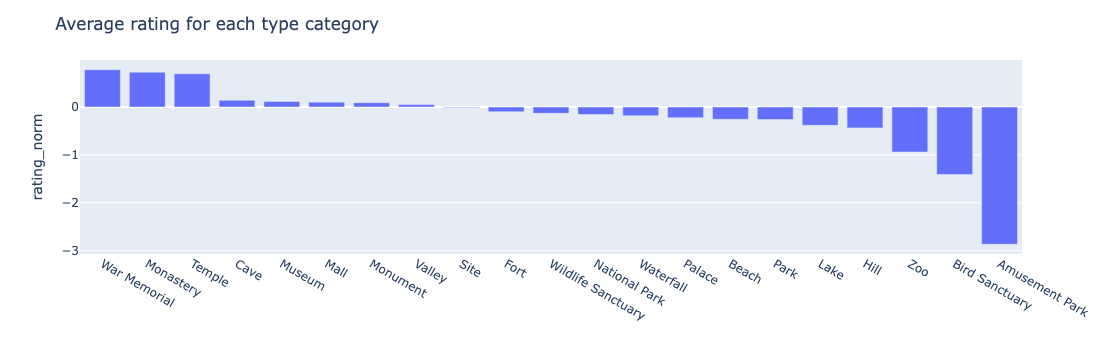

  Source  ddof1  ddof2         F         p-unc       np2
0   type     77    247  2.557954  2.177626e-08  0.443647


category       p-value
0  War Memorial  3.418494e-02
1     Monastery  2.603358e-04
2        Temple  1.221772e-20
3           Zoo  8.655803e-04

In [683]:
categorical('type', 'rating_norm')

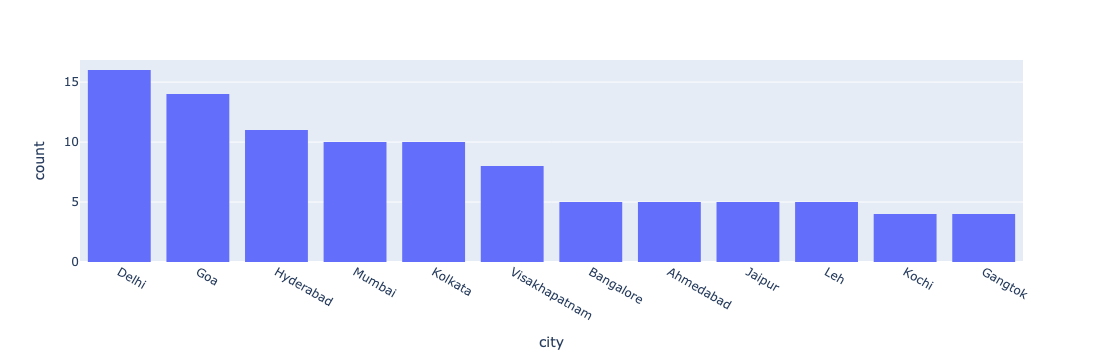

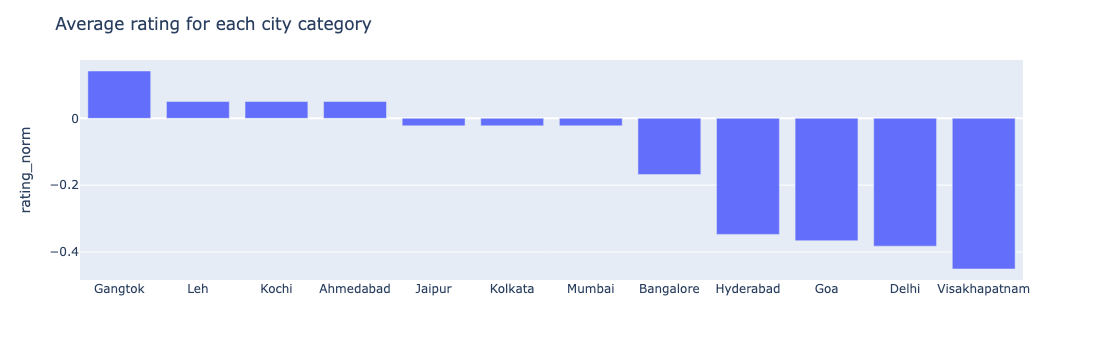

  Source  ddof1  ddof2         F     p-unc       np2
0   city    213    111  0.878711  0.788786  0.627723


category   p-value
0    Delhi  0.047074

In [685]:
categorical('city', 'rating_norm')

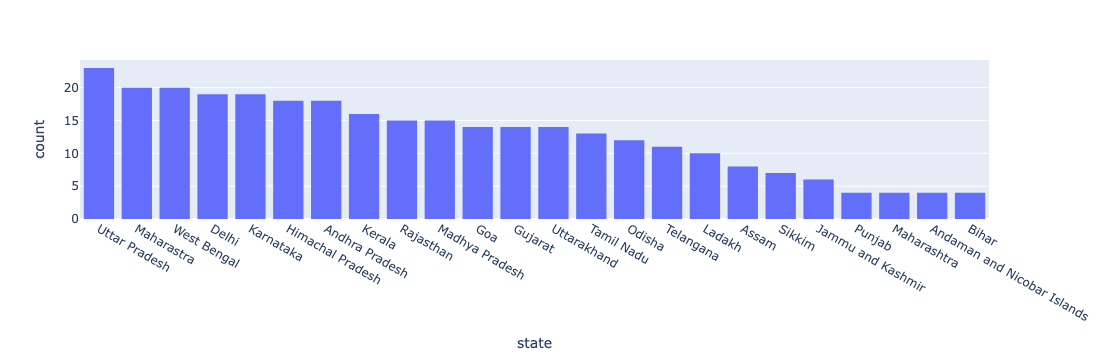

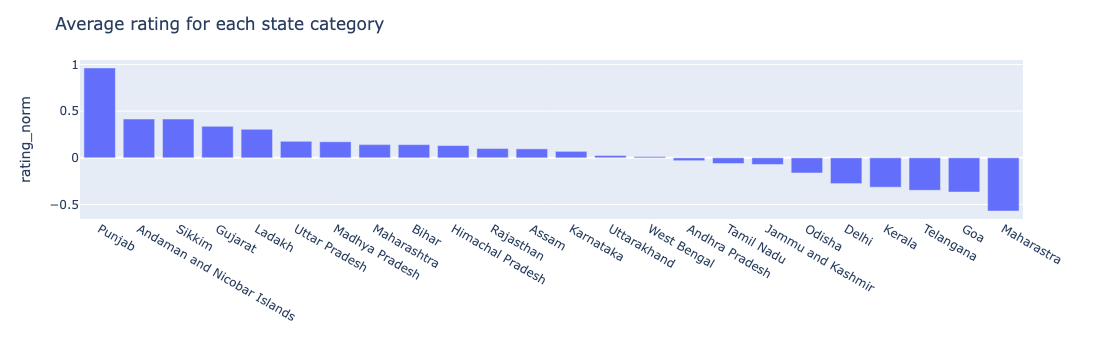

  Source  ddof1  ddof2         F     p-unc       np2
0  state     32    292  0.808365  0.761932  0.081379


In [597]:
categorical('state', 'rating_norm')

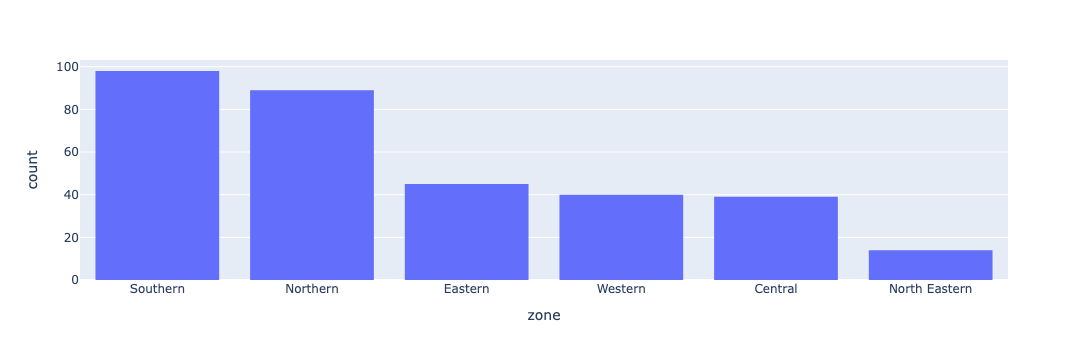

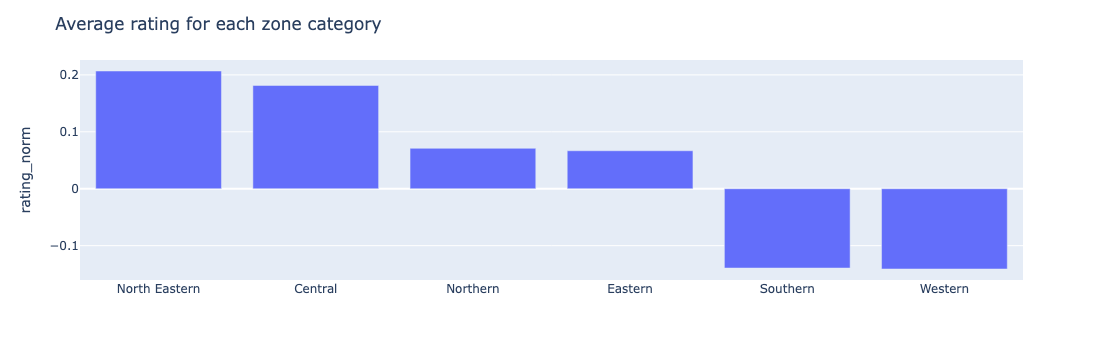

  Source  ddof1  ddof2         F    p-unc       np2
0   zone      5    319  1.043268  0.39215  0.016089


In [689]:
categorical('zone', 'rating_norm')

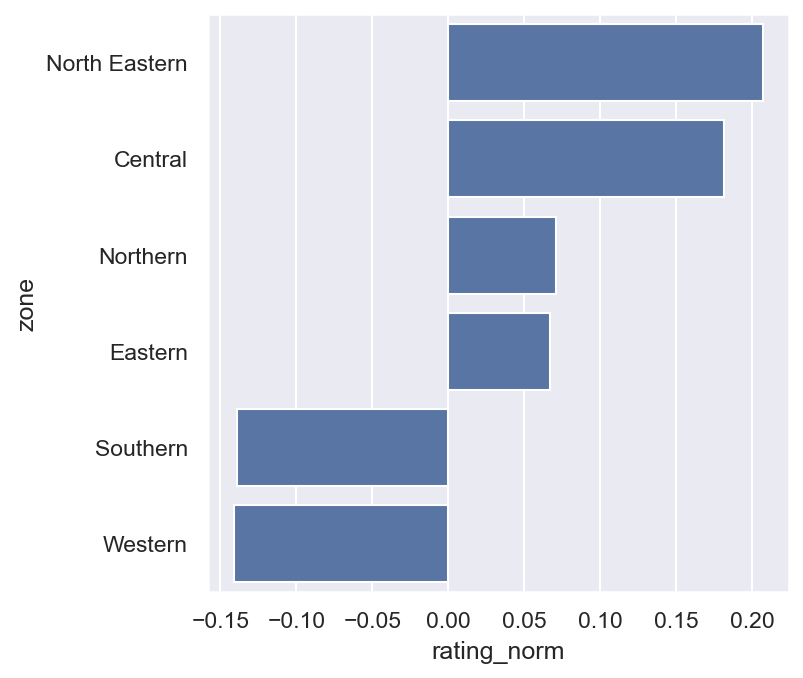

In [2239]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
x = 'zone'
# load dataset
#temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).sort_values('rating_norm', ascending = False)

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x]).mean('rating_norm').sort_values('rating_norm', ascending = False)

# Set the figure size
plt.figure(figsize=(5, 5))

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h');

# Plots

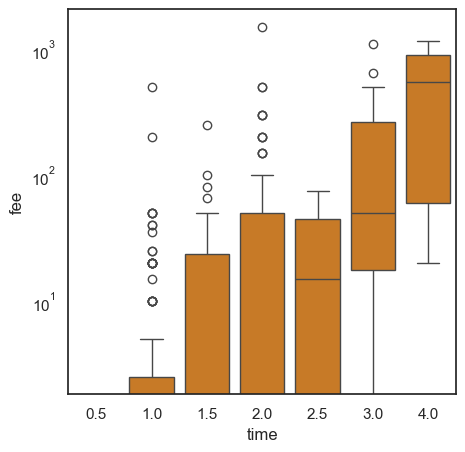

In [1353]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')

y='fee'

temp_df = df.loc[df[['time',y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
ax = sns.boxplot(x="time", y=y, data=temp_df, color = colors[0])


ax.set_yscale('log')

plt.show()

In [35]:
df.groupby('zone').describe()

time                                                rating  \
              count      mean       std  min    25%  50%  75%  max  count   
zone                                                                        
Central        39.0  1.551282  0.559545  1.0  1.000  1.5  2.0  3.0   39.0   
Eastern        45.0  1.566667  0.809040  0.5  1.000  1.5  2.0  4.0   45.0   
North Eastern  14.0  1.857143  0.744946  1.0  1.125  2.0  2.0  3.0   14.0   
Northern       89.0  2.016854  1.139302  0.5  1.000  2.0  2.0  6.0   89.0   
Southern       98.0  1.642857  0.796254  0.5  1.000  1.5  2.0  5.5   98.0   
Western        40.0  2.250000  1.265924  1.0  1.500  2.0  3.0  7.0   40.0   

                                                                fee  \
                   mean       std  min  25%   50%    75%  max count   
zone                                                                  
Central        4.535897  0.224179  3.9  4.4  4.60  4.700  4.8  39.0   
Eastern        4.504444  0.180851  3.9  4.4  4.50  4.600  4.8  45.0   
North Eastern  4.542857  0.160357  4.1  4.5  4.55  4.675  4.7  14.0   
Northern       4.505618  0.232750  3.7  4.4  4.50  4.700  4.9  89.0   
Southern       4.447959  0.223943  3.8  4.4  4.50  4.600  4.8  98.0   
Western        4.447500  0.524276  1.4  4.4  4.50  4.600  4.9  40.0   

                                                                        \
                     mean          std  min  25%   50%     75%     max   
zone                                                                     
Central         59.358974   238.918009  0.0  0.0  10.0   40.00  1500.0   
Eastern         75.222222   372.051981  0.0  0.0   0.0   30.00  2500.0   
North Eastern  120.000000   235.568053  0.0  0.0   0.0   17.50   650.0   
Northern        92.528090   329.086307  0.0  0.0   0.0   50.00  2500.0   
Southern        59.489796   180.471161  0.0  0.0   0.0   23.75  1150.0   
Western        404.825000  1298.298648  0.0  0.0   0.0  225.00  7500.0   

              reviews                                                          \
                count      mean       std   min      25%    50%      75%  max   
zone                                                                            
Central          39.0  0.506192  1.232737  0.01  0.04750  0.100  0.42500  7.4   
Eastern          45.0  0.329378  0.407478  0.01  0.07000  0.130  0.50000  1.8   
North Eastern    14.0  0.118714  0.233698  0.01  0.01375  0.036  0.06725  0.9   
Northern         89.0  0.422056  0.548911  0.01  0.05000  0.230  0.51000  2.6   
Southern         98.0  0.408153  0.514859  0.01  0.09000  0.210  0.49000  2.5   
Western          40.0  0.473875  0.630100  0.02  0.10000  0.285  0.60000  3.6   

              camera_num                                               \
                   count      mean       std  min  25%  50%  75%  max   
zone                                                                    
Central             39.0  0.820513  0.388776  0.0  1.0  1.0  1.0  1.0   
Eastern             45.0  0.777778  0.420437  0.0  1.0  1.0  1.0  1.0   
North Eastern       14.0  0.785714  0.425815  0.0  1.0  1.0  1.0  1.0   
Northern            89.0  0.865169  0.343479  0.0  1.0  1.0  1.0  1.0   
Southern            98.0  0.806122  0.397367  0.0  1.0  1.0  1.0  1.0   
Western             40.0  0.775000  0.422902  0.0  1.0  1.0  1.0  1.0   

              airport_num                                                \
                    count      mean       std  min  25%  50%   75%  max   
zone                                                                      
Central              39.0  0.717949  0.455881  0.0  0.0  1.0  1.00  1.0   
Eastern              45.0  0.800000  0.404520  0.0  1.0  1.0  1.00  1.0   
North Eastern        14.0  0.285714  0.468807  0.0  0.0  0.0  0.75  1.0   
Northern             89.0  0.629213  0.485752  0.0  0.0  1.0  1.00  1.0   
Southern             98.0  0.755102  0.432238  0.0  1.0  1.0  1.00  1.0   
Western              40.0 

In [37]:
df.groupby('year_group').describe()

time                                     \
                                     count      mean       std  min  25%  50%   
year_group                                                                      
Classical Period                      12.0  1.708333  0.721688  1.0  1.0  1.5   
Early Medieval Period                 67.0  1.455224  0.505510  0.5  1.0  1.5   
Independence and Partition            80.0  2.481250  1.296157  0.5  1.5  2.0   
Iron Age                               7.0  1.428571  0.449868  1.0  1.0  1.5   
Late Medieval Period                  19.0  1.368421  0.522869  1.0  1.0  1.0   
Late Modern and Contemporary Period   27.0  1.648148  0.731369  0.5  1.0  1.5   
Prehistoric                            1.0  1.500000       NaN  1.5  1.5  1.5   
Unknown                              112.0  1.687500  0.841291  0.5  1.0  1.5   

                                               rating                      \
                                      75%  max  count      mean       std   
year_group                                                                  
Classical Period                     2.00  3.0   12.0  4.650000  0.138170   
Early Medieval Period                2.00  3.0   67.0  4.519403  0.161657   
Independence and Partition           3.00  7.0   80.0  4.417500  0.407765   
Iron Age                             1.75  2.0    7.0  4.671429  0.095119   
Late Medieval Period                 1.50  3.0   19.0  4.500000  0.233333   
Late Modern and Contemporary Period  2.00  3.0   27.0  4.481481  0.225383   
Prehistoric                          1.50  1.5    1.0  4.800000       NaN   
Unknown                              2.00  6.0  112.0  4.482143  0.230242   

                                                                   fee  \
                                     min   25%  50%    75%  max  count   
year_group                                                               
Classical Period                     4.4  4.60  4.7  4.725  4.8   12.0   
Early Medieval Period                4.1  4.40  4.5  4.600  4.9   67.0   
Independence and Partition           1.4  4.30  4.5  4.600  4.8   80.0   
Iron Age                             4.5  4.65  4.7  4.700  4.8    7.0   
Late Medieval Period                 3.9  4.40  4.6  4.700  4.8   19.0   
Late Modern and Contemporary Period  3.9  4.40  4.5  4.600  4.8   27.0   
Prehistoric                          4.8  4.80  4.8  4.800  4.8    1.0   
Unknown                              3.7  4.40  4.5  4.600  4.9  112.0   

                                                                             \
                                           mean         std  min  25%   50%   
year_group                                                                    
Classical Period                      33.750000   41.293022  0.0  0.0  30.0   
Early Medieval Period                 24.701493   46.830453  0.0  0.0  10.0   
Independence and Partition           257.475000  573.547499  0.0  0.0  32.5   
Iron Age                              10.714286   16.938263  0.0  0.0   0.0   
Late Medieval Period                  16.842105   25.177731  0.0  0.0  10.0   
Late Modern and Contemporary Period  190.555556  494.330031  0.0  0.0  25.0   
Prehistoric                            0.000000         NaN  0.0  0.0   0.0   
Unknown                               84.285714  710.335810  0.0  0.0   0.0   

                                                   reviews            \
                                       75%     max   count      mean   
year_group                                                             
Classical Period                      42.5   150.0    12.0  0.298417   
Early Medieval Period                 35.0   300.0    67.0  0.534209   
Independence and Partition           150.0  3500.0    80.0  0.438587   
Iron Age                              17.5    40.0     7.0  0.196429   
Late Medieval Period                  20.0   100.0    19.0  0.328500   
Late Modern and Contemporary Period  

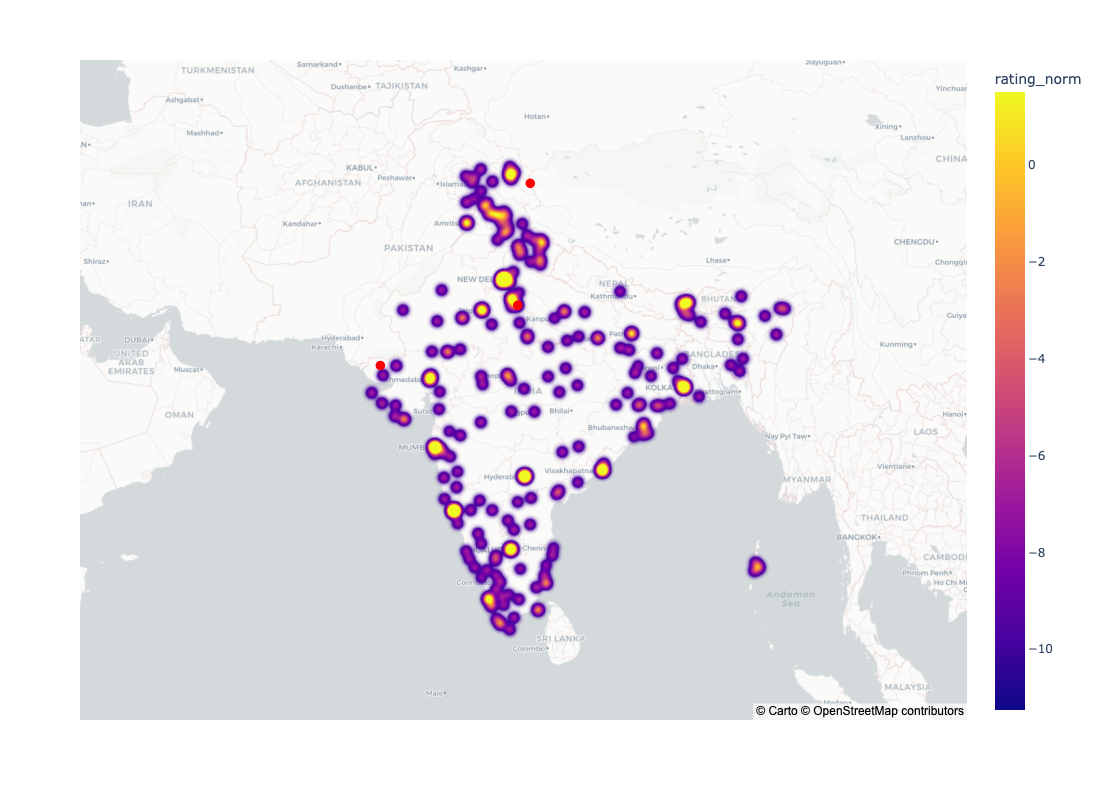

In [2321]:
# Create the heatmap

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='rating_norm',
                        radius=10, center=dict(lat=22.4, lon=78.4),
                        zoom=3.5, mapbox_style="carto-positron", hover_name = 'city')

fig.update_layout(width = 800, height = 800)

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Taj Mahal')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Pangong Tso')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Rann Utsav')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False))

fig.show()

In [2265]:
df_geo[df_geo['zone'

zone           state         city                          name  \
0    Northern           Delhi        Delhi                    India Gate   
1    Northern           Delhi        Delhi                Humayun's Tomb   
2    Northern           Delhi        Delhi             Akshardham Temple   
3    Northern           Delhi        Delhi          Waste to Wonder Park   
4    Northern           Delhi        Delhi                 Jantar Mantar   
..        ...             ...          ...                           ...   
320   Western         Gujarat  Gandhinagar                    Akshardham   
321   Central   Uttar Pradesh         Agra                     Agra Fort   
322   Central  Madhya Pradesh       Bhopal  Madhya Pradesh Tribal Museum   
323  Northern       Rajasthan       Jaipur                   City Palace   
324  Northern       Rajasthan       Jaipur            Albert Hall Museum   

             type  year  time  rating  fee airport     off   significance  \
0    War Memorial  1921   0.5     4.6    0     Yes    None     Historical   
1            Tomb  1572   2.0     4.5   30     Yes    None     Historical   
2          Temple  2005   5.0     4.6   60     Yes    None      Religious   
3      Theme Park  2019   2.0     4.1   50     Yes  Monday  Environmental   
4     Observatory  1724   2.0     4.2   15     Yes    None     Scientific   
..            ...   ...   ...     ...  ...     ...     ...            ...   
320        Temple  1992   3.0     4.6    0     Yes  Monday      Religious   
321          Fort  1565   2.0     4.5   40     Yes    None     Historical   
322        Museum  2013   2.0     4.7   10     Yes  Monday       Cultural   
323        Palace  1727   2.0     4.4  200     Yes    None     Historical   
324        Museum  1887   2.0     4.5  200     Yes    None     Historical   

    camera  reviews      visit  camera_num  airport_num  anytime  year_num  \
0      Yes     2.60    Evening           1            1    False    1921.0   
1      Yes     0.40  Afternoon           1            1    False    1572.0   
2       No     0.40  Afternoon           0            1    False    2005.0   
3      Yes     0.27    Evening           1            1    False    2019.0   
4      Yes     0.31    Morning           1            1    False    1724.0   
..     ...      ...        ...         ...          ...      ...       ...   
320     No     0.18    Anytime           0            1    False    1992.0   
321    Yes     1.30  Afternoon           1            1    False    1565.0   
322    Yes     0.15    Anytime           1            1    False    2013.0   
323    Yes     0.51    Morning           1            1    False    1727.0   
324    Yes     0.63    Anytime           1            1    False    1887.0   

                              year_group  cost_ratio  rating_norm   fee_log  \
0    Late Modern and Contemporary Period         0.0     0.415259  0.000000   
1                  Early Medieval Period        15.0     0.050504  3.433987   
2             Independence and Partition        12.0     0.415259  4.110874   
3             Independence and Partition        25.0    -1.408513  3.931826   
4                  Early Medieval Period         7.5    -1.043759  2.772589   
..                                   ...         ...          ...       ...   
320           Independence and Partition         0.0     0.415259  0.000000   
321                Early Medieval Period        20.0     0.050504  3.713572   
322           Independence and Partition         5.0     0.780013  2.397895   
323                Early Medieval Period       100.0    -0.314250  5.303305   
324  Late Modern and Contemporary Period       100.0     0.050504  5.303305   

     reviews_log  cost_ratio_log        lat        lon  
0       1.280934        0.000000  28.627393  77.171695  
1       0.336472        2.772589  28.627393  77.171695  
2       0.336472        2.564949  28.627393  77.171695  
3       0.239017        3.258097  28.627393  77.171695  


In [2287]:
df_geo[df_geo['zone'] == 'North Eastern']

zone              state           city  \
273  North Eastern              Assam       Guwahati   
274  North Eastern              Assam      Kaziranga   
275  North Eastern              Assam       Guwahati   
276  North Eastern              Assam      Sivasagar   
277  North Eastern              Assam         Majuli   
278  North Eastern              Assam          Manas   
279  North Eastern              Assam           Hajo   
280  North Eastern              Assam       Guwahati   
281  North Eastern  Arunachal Pradesh         Tawang   
282  North Eastern            Tripura       Agartala   
283  North Eastern            Tripura        Dumboor   
284  North Eastern            Tripura        Unakoti   
286  North Eastern           Nagaland  Dzükou Valley   
319  North Eastern          Meghalaya    Cherrapunji   

                            name                type     year  time  rating  \
273              Kamakhya Temple              Temple  Unknown   2.0     4.6   
274      Kaziranga National Park       National Park     1905   3.0     4.5   
275              Umananda Island              Island  Unknown   1.0     4.1   
276            Sivasagar Sivadol              Temple     1734   1.0     4.7   
277                Majuli Island        River Island  Unknown   2.0     4.7   
278          Manas National Park       National Park     1990   3.0     4.6   
279     Hayagriva Madhava Temple              Temple  Unknown   1.0     4.5   
280  Pobitora Wildlife Sanctuary  Wildlife Sanctuary     1987   2.0     4.4   
281             Tawang Monastery           Monastery     1680   2.0     4.7   
282             Ujjayanta Palace              Palace     1901   1.5     4.5   
283                 Dumboor Lake                Lake  Unknown   1.0     4.5   
284        Unakoti Rock Carvings       Rock Carvings      700   1.5     4.5   
286                Dzükou Valley              Valley  Unknown   3.0     4.7   
319           Living Root Bridge     Natural Feature  Unknown   2.0     4.6   

     fee airport     off significance camera  reviews      visit  camera_num  \
273    0     Yes    None    Religious     No    0.210    Anytime           0   
274  650      No    None     Wildlife     No    0.068    Morning           0   
275    0     Yes    None       Nature    Yes    0.010    Morning           1   
276    0      No    None   Historical    Yes    0.065    Anytime           1   
277    0      No    None     Cultural    Yes    0.010    Morning           1   
278  500      No    None     Wildlife    Yes    0.190    Morning           1   
279    0      No    None    Religious    Yes    0.900    Anytime           1   
280  500     Yes    None     Wildlife    Yes    0.037    Anytime           1   
281    0      No    None    Religious     No    0.032    Morning           0   
282   10     Yes  Monday   Historical    Yes    0.035    Anytime           1   
283    0      No    None       Nature    Yes    0.010    Morning           1   
284   20      No    None   Historical    Yes    0.025    Morning           1   
286    0      No    None     Trekking    Yes    0.010  Afternoon           1   
319    0      No    None       Nature    Yes    0.060    Morning           1   

     airport_num  anytime  year_num                           year_group  \
273            1    False       NaN                              Unknown   
274            0    False    1905.0  Late Modern and Contemporary Period   
275            1    False       NaN                              Unknown   
276            0    False    1734.0                Early Medieval Period   
277            0    False       NaN                              Unknown   
278            0    False    1990.0           Independence and Partition   
279            0    False       NaN                              Unknown   
280            1    False    1987.0           Independence and Partition   
281            0    False    1680.0                Early Medieval Period   
282            1    False 

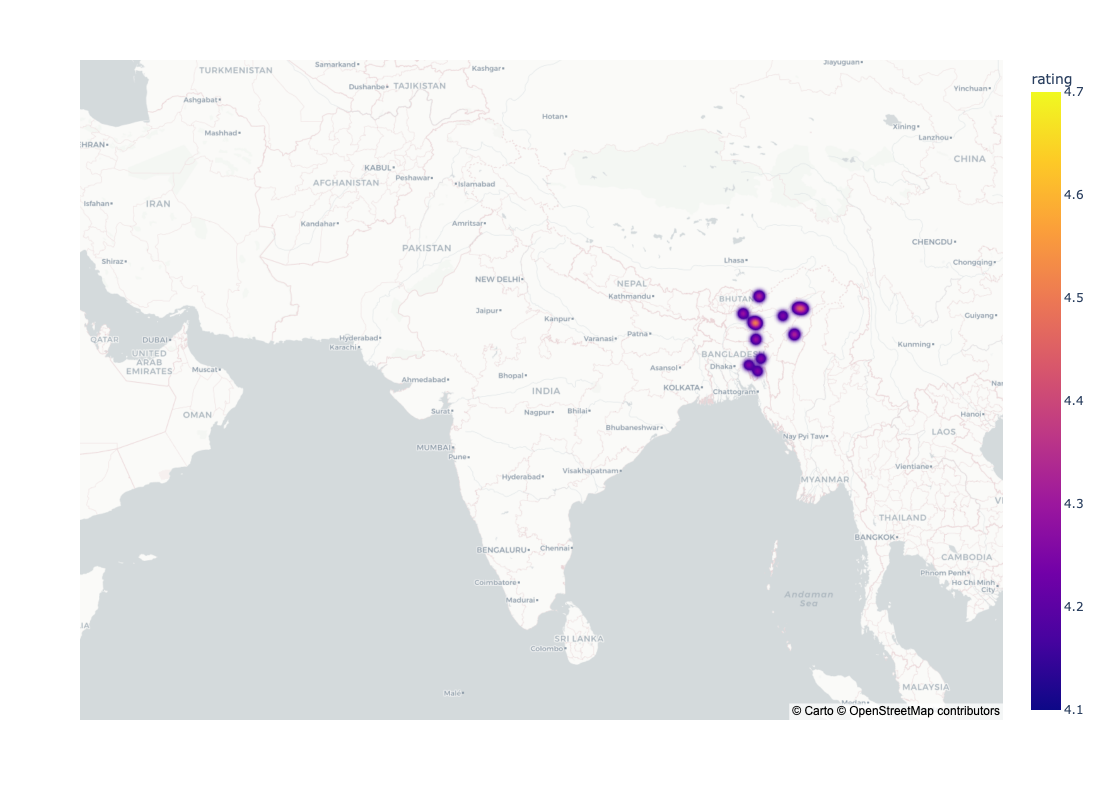

In [2317]:
# Create the heatmap
temp_df = df_geo

temp_df = df_geo[df_geo['zone'] == 'North Eastern']


fig = px.density_mapbox(temp_df, lat='lat', lon='lon', z='rating',
                        radius=10, center=dict(lat=22.4, lon=78.4),
                        zoom=3.5, mapbox_style="carto-positron", hover_name = 'city')

fig.update_layout(width = 800, height = 800)

fig.show()

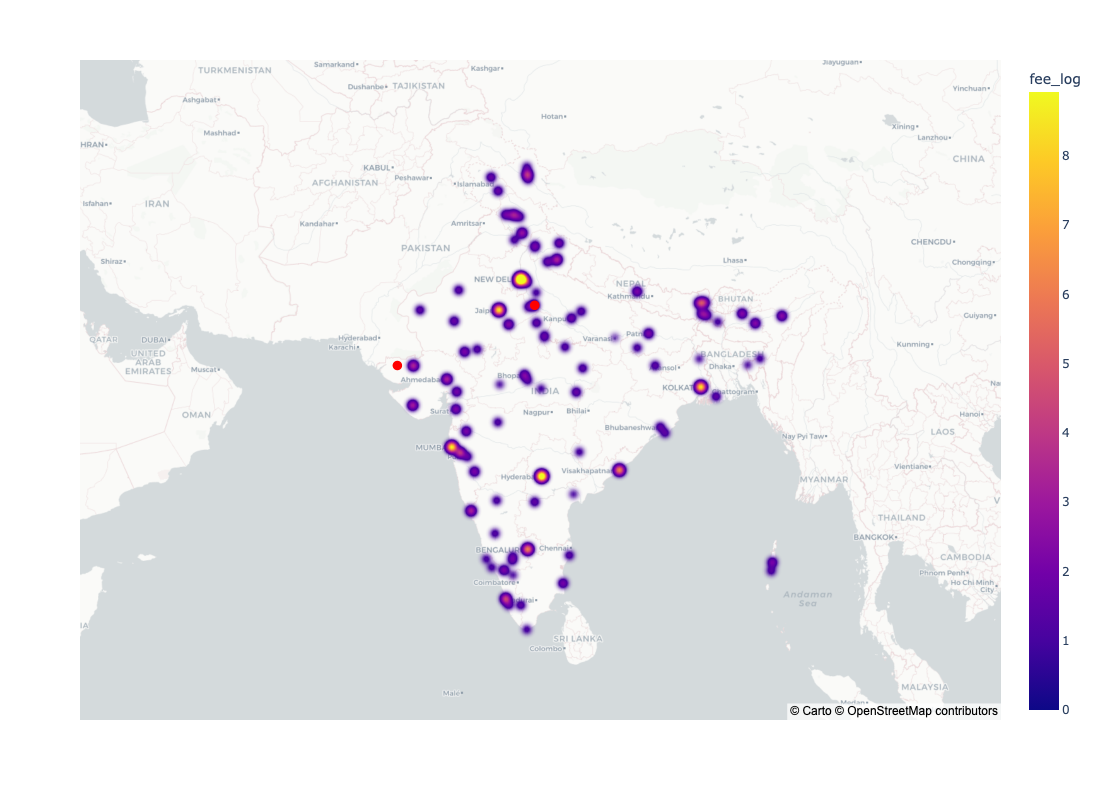

In [2293]:
# Create the heatmap

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='fee_log',
                        radius=10, center=dict(lat=22.4, lon=78.4),
                        zoom=3.5, mapbox_style="carto-positron", hover_name = 'city')

fig.update_layout(width = 800, height = 800)

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Taj Mahal')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Rann Utsav')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False))

fig.show()

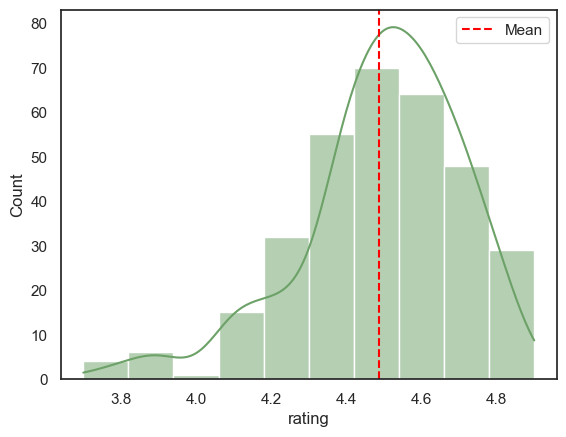

In [865]:
sns.set_theme(style="white")

# Get a palette from PyPalettes
colors = get_hex('Balistapus_undulatus') 

temp_df = df.loc[df[['rating']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.histplot(data=temp_df, x="rating", bins=10, kde=True, color=colors[2])

mean = np.mean(df['rating'])
plt.axvline(mean, color='red', linestyle='--', label='Mean')


plt.savefig("rating.png")
plt.show()

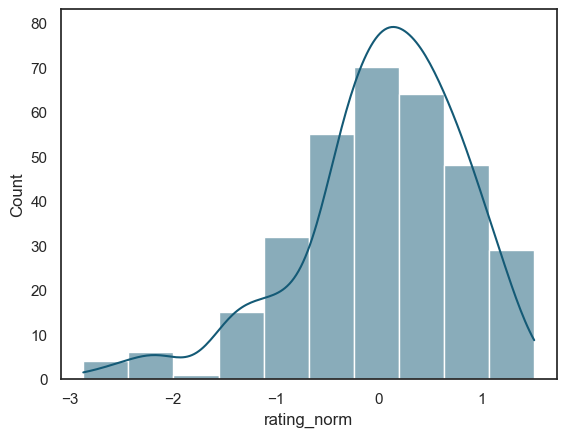

In [873]:
sns.set_theme(style="white")
# Get a palette from PyPalettes
colors = get_hex('Balistapus_undulatus') 

temp_df = df.loc[df[['rating_norm']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.histplot(data=temp_df, x="rating_norm", bins=10, kde=True, color=colors[3])
plt.savefig("rating_norm.png")
plt.show()

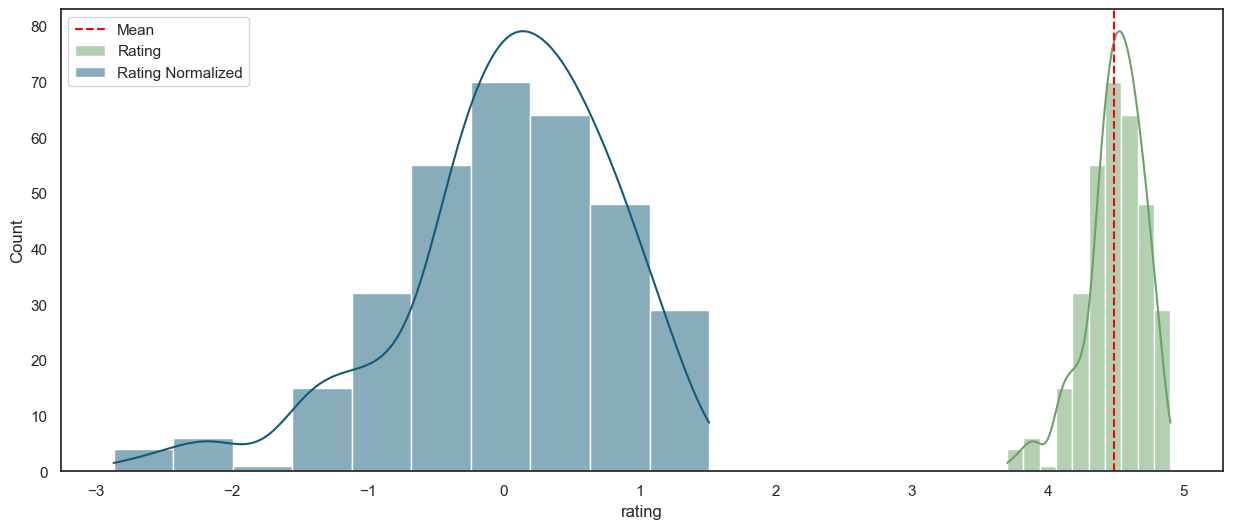

In [905]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus') 

temp_df = df.loc[df[['rating']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.histplot(data=temp_df, x="rating", bins=10, kde=True, color=colors[2], label ='Rating')

temp_df = df.loc[df[['rating_norm']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.histplot(data=temp_df, x="rating_norm", bins=10, kde=True, color=colors[3], label = 'Rating Normalized')

mean = np.mean(df['rating'])
plt.axvline(mean, color='red', linestyle='--', label='Mean')

plt.legend()
plt.show()

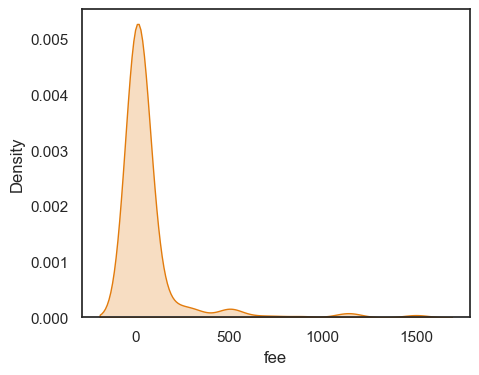

In [1047]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')
plt.figure(figsize=(5, 4))

temp_df = df.loc[df[['fee']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]


sns.kdeplot(temp_df['fee'], fill=True, color=colors[0])
#sns.kdeplot(df['cost_ratio'], fill=True, color="b")
plt.show()

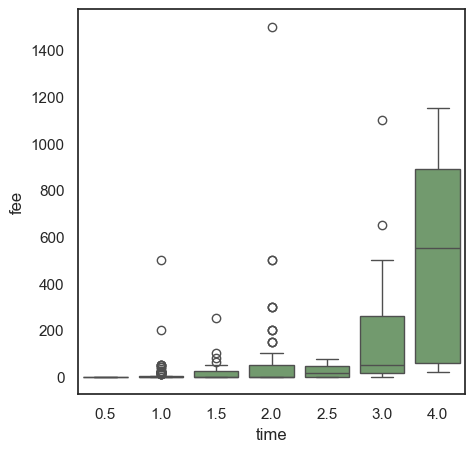

In [1439]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')

y='fee'

temp_df = df.loc[df[['time',y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
ax = sns.boxplot(x="time", y=y, data=temp_df, color = colors[2])

#ax.set_yscale('log')

plt.show()

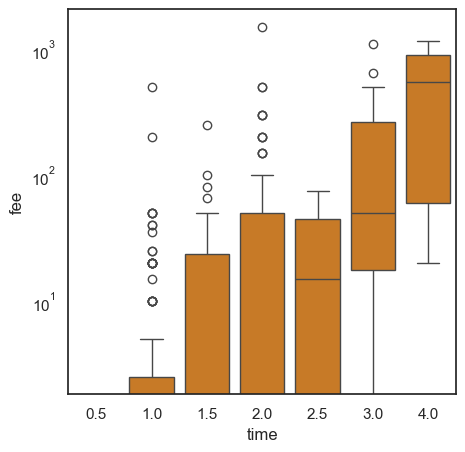

In [1353]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')

y='fee'

temp_df = df.loc[df[['time',y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
ax = sns.boxplot(x="time", y=y, data=temp_df, color = colors[0])


ax.set_yscale('log')

plt.show()

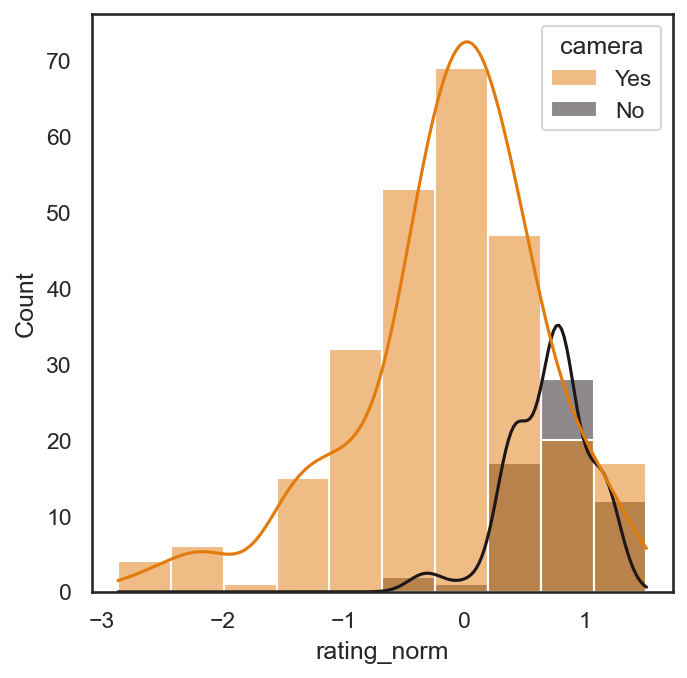

In [1473]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')


temp_df = df.loc[df[['rating_norm']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.histplot(data=temp_df, x="rating_norm", bins=10, kde=True, hue = 'camera', palette={'Yes': colors[0], 'No': colors[4]})
plt.show()

In [1499]:
x='year_num'
y='rating_norm'
colors = get_hex('Balistapus_undulatus')

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

temp_df.loc[df['name'] == 'Taj Mahal']['year_num'].iloc[0]

1632.0

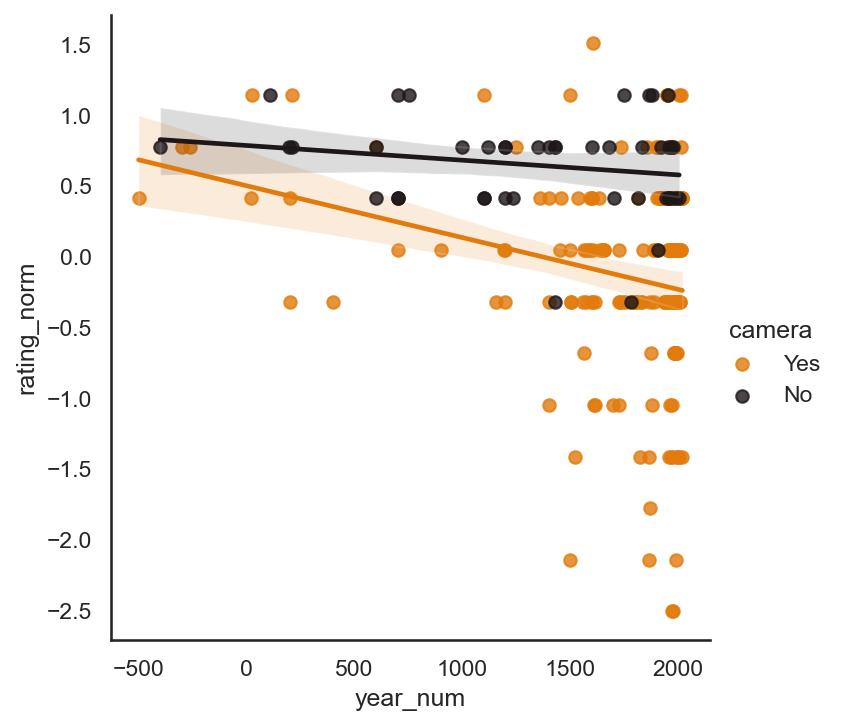

In [1507]:
x='year_num'
y='rating_norm'
colors = get_hex('Balistapus_undulatus')

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.lmplot(
    x=x,
    y=y,
    data=temp_df,
    hue='camera', palette={'Yes': colors[0], 'No': colors[4]}
)

a = temp_df.loc[df['name'] == 'Taj Mahal']['year_num'].iloc[0]
b = temp_df.loc[df['name'] == 'Taj Mahal']['rating'].iloc[0]

plt.annotate('Taj Mahal', (a, b))
plt.show()

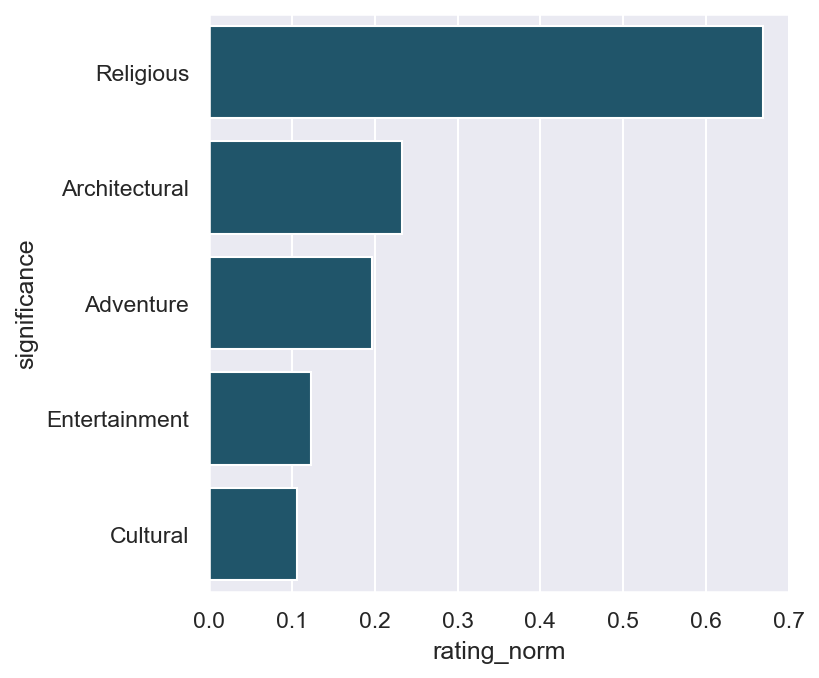

In [2131]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
x = 'significance'
colors = get_hex('Balistapus_undulatus')
# load dataset

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x]).mean('rating_norm').sort_values('rating_norm', ascending = False).head(5)

# Set the figure size
plt.figure(figsize=(5, 5))

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h', color = colors[3]);

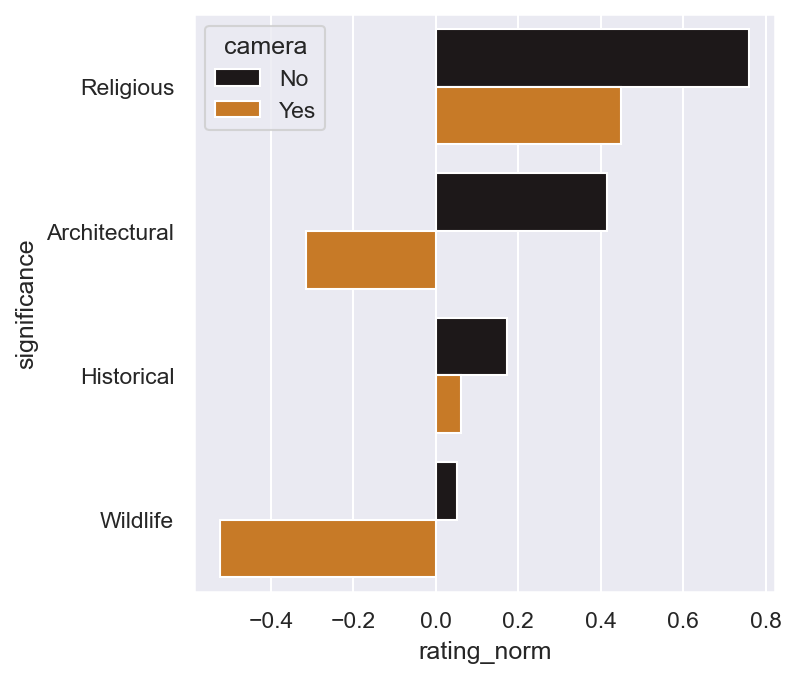

In [2155]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
x = 'significance'
colors = get_hex('Balistapus_undulatus')

# load dataset

filter_df = df[df['camera'] == 'No']
temp_df = df[df['significance'].isin(filter_df['significance'].unique())]

temp_df = temp_df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x, 'camera']).mean('rating_norm').sort_values('rating_norm', ascending = False)

# Set the figure size
plt.figure(figsize=(5, 5))

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h', 
            hue = 'camera', palette = {'No':colors[4], 'Yes':colors[0]});

<Axes: xlabel='rating_norm', ylabel='type'>

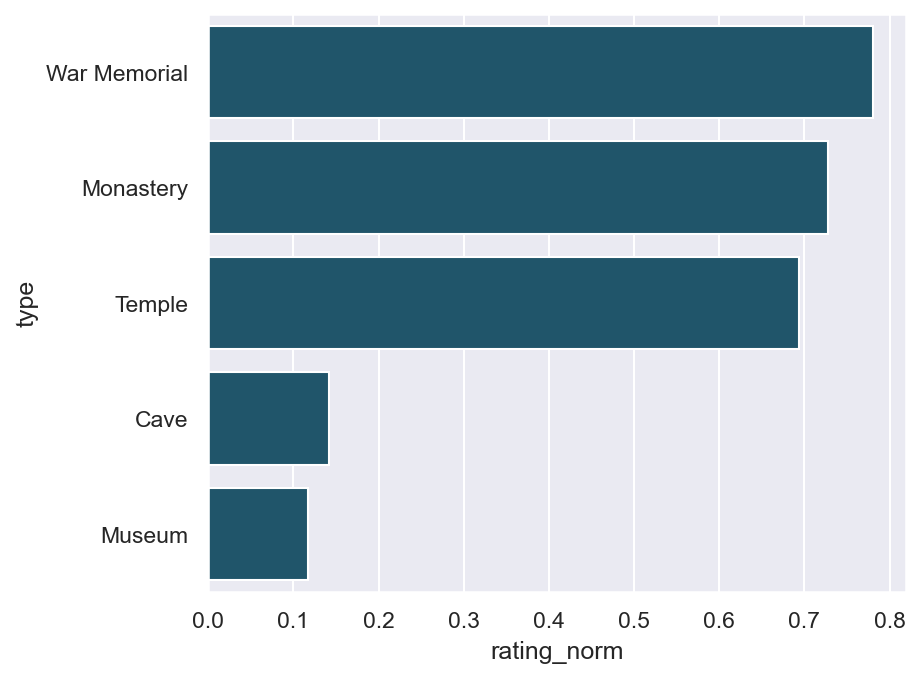

In [2229]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
colors = get_hex('Balistapus_undulatus')

x = 'type'

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x]).mean('rating_norm').sort_values('rating_norm', ascending = False).head(5)

# Set the figure size
plt.figure(figsize=(6, 5))

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h', color = colors[3])

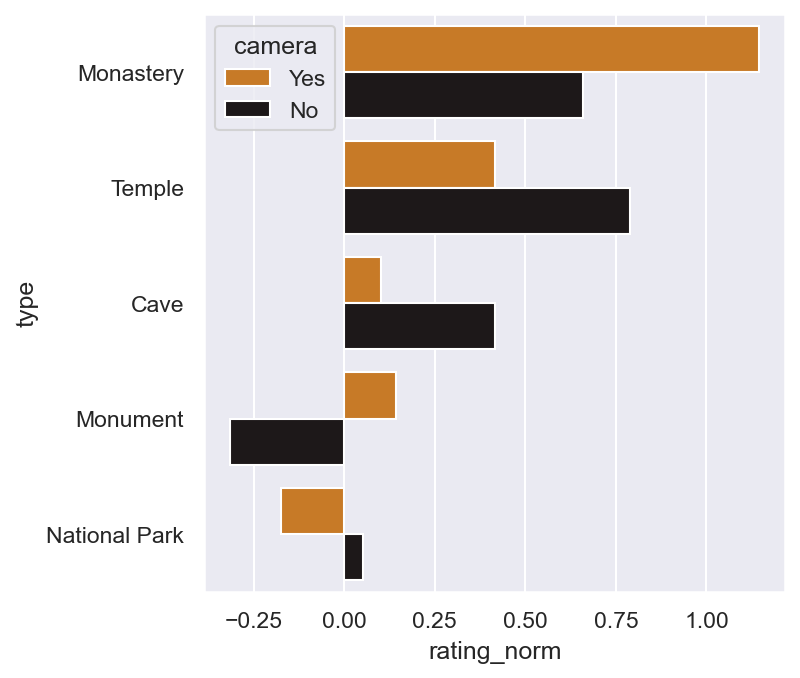

In [2233]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
colors = get_hex('Balistapus_undulatus')
x = 'type'
# load dataset

filter_df = df[df['camera'] == 'No']
temp_df = df[df[x].isin(filter_df[x].unique())]


temp_df1 = temp_df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x, 'camera']).mean('rating_norm')[['rating_norm']]


temp_df2 = temp_df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x]).mean('rating_norm').sort_values('rating_norm', ascending = False)[['rating_norm']].rename(columns={'rating_norm':'Avg'})

temp_df = temp_df1.join(temp_df2).sort_values('Avg', ascending = False)

# Set the figure size
plt.figure(figsize=(5, 5))

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h', 
            hue = 'camera', palette = {'No':colors[4], 'Yes':colors[0]});